# Stage 5: Constrained and Targeted Experiments

**Primary author:** Victoria
**Builds on:** `04_clustering.ipynb` (Stage 4: unconstrained clustering results)
**Prompt engineering:** Victoria
**AI assistance:** Claude (Anthropic)
**Environment:** Great Lakes (for definitions embedding); Colab (for subset experiments); Local (for label evaluation)

**Research question: "Does expert knowledge improve clustering, and do theoretically
motivated subsets behave as predicted?"**

Stage 4 asked what structure emerges when we let clustering algorithms explore freely.
The answer: strong local structure at fine granularity (282 HDBSCAN clusters, metrics
improving up to k=250 for agglomerative), but no natural k=8 grouping and no stable
intermediate level in HDBSCAN.

This notebook introduces domain knowledge for the first time:
- **Wordplay type labels** (Ho blog labels and algorithmically derived GT labels) to
  evaluate whether unconstrained clusters correspond to known types
- **Seed words** from expert sources to guide constrained clustering
- **Subset experiments** to test specific hypotheses about which types should be easy
  vs. hard to separate

The four sections:
1. **Setup, Load Data, Build Label Sets** — load all inputs and create per-indicator
   label mappings
2. **Label-Based Evaluation of NB 04 Results** — overlay labels on unconstrained
   clusters to see what they captured
3. **Constrained Agglomerative Clustering** — use seed words to guide clustering
4. **Subset Experiments** — test separation and overlap hypotheses on targeted subsets

## Running on Google Colab

If running on Google Colab:

1. Go to **Runtime > Change runtime type**
2. A GPU is not required for Sections 1-2 (label evaluation). GPU is needed only for
   definitions embedding in Section 3.
3. Click **Save**, then run all cells

---
## Section 1: Setup and Data Preparation

### Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['figure.dpi'] = 120
np.random.seed(42)

### Environment Auto-Detection and Paths

In [2]:
# --- Environment Auto-Detection ---
try:
    IS_COLAB = 'google.colab' in str(get_ipython())
except NameError:
    IS_COLAB = False

IS_GREATLAKES = 'SLURM_JOB_ID' in os.environ

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = Path('/content/drive/MyDrive/SIADS 692 Milestone II/Milestone II - NLP Cryptic Crossword Clues')
elif IS_GREATLAKES:
    # Update YOUR_UNIQNAME to your actual UMich uniqname
    PROJECT_ROOT = Path('/scratch/YOUR_UNIQNAME/ccc_project')
else:
    try:
        PROJECT_ROOT = Path(__file__).resolve().parent.parent
    except NameError:
        PROJECT_ROOT = Path.cwd().parent

DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')
print(f'Data directory: {DATA_DIR}')
print(f'Output directory: {OUTPUT_DIR}')
print(f'Figures directory: {FIGURES_DIR}')

Project root: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering
Data directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/data
Output directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs
Figures directory: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures


### Input File Validation

This notebook requires outputs from Stages 1–4. We check that all required files exist
before proceeding, rather than failing partway through.

| File | Produced by | Description |
|------|-------------|-------------|
| `embeddings_umap_10d.npy` | Stage 3 | 10D UMAP embeddings for clustering |
| `embeddings_umap_2d.npy` | Stage 3 | 2D UMAP embeddings for visualization |
| `indicator_index_all.csv` | Stage 2 | Row-to-indicator-string mapping |
| `verified_clues_labeled.csv` | Stage 1 | Clue-indicator pairs with Ho and GT labels |
| `cluster_labels_hdbscan_eps_0p0000.csv` | Stage 4 | Best HDBSCAN labels (eps=0.0) |
| `cluster_labels_agglo_k8.csv` | Stage 4 | Agglomerative k=8 labels |
| `cluster_labels_agglo_k10.csv` | Stage 4 | Agglomerative k=10 labels |
| `cluster_labels_agglo_k34.csv` | Stage 4 | Agglomerative k=34 labels |
| `clustering_metrics_summary.csv` | Stage 4 | Metrics from all Stage 4 runs |
| `wordplay_seeds.xlsx` | Manual (expert) | Seed words for constrained clustering (Section 3) |

**New in this notebook:** `verified_clues_labeled.csv` and `wordplay_seeds.xlsx`. These
were deliberately excluded from Notebook 04 to keep the unconstrained analysis label-free.
This is where domain knowledge enters the clustering pipeline for the first time.

In [3]:
required_files = {
    # Stage 2-3: embeddings
    'embeddings_umap_10d.npy': 'Run 03_dimensionality_reduction.ipynb',
    'embeddings_umap_2d.npy': 'Run 03_dimensionality_reduction.ipynb',
    'indicator_index_all.csv': 'Run 02_embedding_generation.ipynb',
    # Stage 1: labels
    'verified_clues_labeled.csv': 'Run 01_data_cleaning.ipynb',
    # Stage 4: cluster assignments
    'cluster_labels_hdbscan_eps_0p0000.csv': 'Run 04_clustering.ipynb',
    'cluster_labels_agglo_k8.csv': 'Run 04_clustering.ipynb',
    'cluster_labels_agglo_k10.csv': 'Run 04_clustering.ipynb',
    'cluster_labels_agglo_k34.csv': 'Run 04_clustering.ipynb',
    # Seed words (used in Section 3)
    'wordplay_seeds.xlsx': 'Manually created from expert sources (Minute Cryptic, CC for Dummies)',
}

# Metrics summary is in OUTPUT_DIR, not DATA_DIR
required_output_files = {
    'clustering_metrics_summary.csv': 'Run 04_clustering.ipynb',
}

all_ok = True
for fname, fix_msg in required_files.items():
    fpath = DATA_DIR / fname
    if not fpath.exists():
        print(f'MISSING: {fpath}')
        print(f'  Fix: {fix_msg}')
        all_ok = False

for fname, fix_msg in required_output_files.items():
    fpath = OUTPUT_DIR / fname
    if not fpath.exists():
        print(f'MISSING: {fpath}')
        print(f'  Fix: {fix_msg}')
        all_ok = False

if all_ok:
    print('All input files found.')
else:
    raise FileNotFoundError('One or more required files are missing. See messages above.')

All input files found.


### Load Embeddings and Indicator Index

These are the same files loaded in Notebook 04. The 10D embeddings are used for
clustering; the 2D embeddings are used for scatter plot visualization. The indicator
index maps each row number to its indicator string.

In [4]:
# Load UMAP embeddings
embeddings_10d = np.load(DATA_DIR / 'embeddings_umap_10d.npy')
embeddings_2d = np.load(DATA_DIR / 'embeddings_umap_2d.npy')

# Load indicator index (maps row i -> indicator string)
df_index = pd.read_csv(DATA_DIR / 'indicator_index_all.csv', index_col=0)
indicator_names = df_index['indicator'].values

n_indicators = len(df_index)
print(f'10D embeddings shape: {embeddings_10d.shape}')
print(f'2D embeddings shape:  {embeddings_2d.shape}')
print(f'Indicator count:      {n_indicators:,}')

assert embeddings_10d.shape == (n_indicators, 10)
assert embeddings_2d.shape == (n_indicators, 2)
print('Shape checks passed.')

10D embeddings shape: (12622, 10)
2D embeddings shape:  (12622, 2)
Indicator count:      12,622
Shape checks passed.


### Load Wordplay Labels

**This is the first time labels enter the clustering pipeline.**

`verified_clues_labeled.csv` contains one row per verified (clue_id, indicator) pair —
76,015 rows total. Each row carries two kinds of wordplay labels:

#### Ho Labels (`wordplay_ho`)

These are the original wordplay type labels parsed from cryptic crossword blog
commentary by George Ho. They cover **all 8 wordplay types**: anagram, reversal,
hidden, container, insertion, deletion, homophone, and alternation. Every row in the
file has a Ho label.

**Strengths:** Complete coverage of all types; large sample size.
**Weaknesses:** Parsed from informal blog text, so some labels may be noisy or
inconsistent. The parsing treats the blogger's description as ground truth, but
bloggers occasionally mislabel or use ambiguous terminology.

#### GT Labels (`wordplay_gt`)

These are algorithmically derived "ground truth" labels produced by Victoria's
verification code in Stage 1. The algorithm checks whether the answer can be
mechanically derived from the clue components using the rules of each wordplay type.
It covers **only 4 types**: hidden, reversal, alternation, and anagram — the types
where the transformation can be verified algorithmically (e.g., checking that the
answer's letters appear consecutively in the fodder for hidden-word clues).

**Strengths:** High precision — if the algorithm says it's a hidden-word indicator,
the mechanical check confirms it. No human judgment involved.
**Weaknesses:** Only 4 of 8 types are covered. Container, insertion, deletion, and
homophone require contextual understanding that the algorithm cannot perform. About
74% of rows have no GT label.

#### Why Both Matter

Neither label set supersedes the other:
- **Ho labels** give us full coverage but lower precision
- **GT labels** give us high precision but partial coverage

When they disagree, that's informative — it highlights indicators where the blog
commentary and the mechanical verification diverge. The `label_match` column tracks
this agreement (92.6% match rate where GT exists).

#### Multi-Label Indicators

A single indicator string can appear under **multiple wordplay types**. For example,
"about" is used as a container indicator, a reversal indicator, and an anagram
indicator in different clues. This is linguistically real — the word genuinely serves
multiple functions — not parsing noise. In `verified_clues_labeled.csv`, such an
indicator appears in multiple rows with different `wordplay_ho` values.

For this analysis, we build:
- A **label set** per indicator: all Ho (or GT) types it appears under (for overlay
  plots where a multi-label indicator should appear in every relevant type's subplot)
- A **primary label**: the single most frequent Ho (or GT) type across that
  indicator's clue appearances (for heatmaps and coloring where a single assignment
  is needed)

In [5]:
# Load the full labels file
df_labels = pd.read_csv(DATA_DIR / 'verified_clues_labeled.csv')

print(f'Labels file: {len(df_labels):,} rows')
print(f'Unique indicators: {df_labels["indicator"].nunique():,}')
print(f'\nHo label distribution (instance-level):')
print(df_labels['wordplay_ho'].value_counts().to_string())
print(f'\nGT label distribution (NaN = no GT label):')
print(df_labels['wordplay_gt'].value_counts(dropna=False).to_string())

Labels file: 76,015 rows
Unique indicators: 12,622

Ho label distribution (instance-level):
wordplay_ho
anagram        38226
container      10836
reversal       10149
insertion       8305
homophone       3642
hidden          2595
deletion        1608
alternation      654

GT label distribution (NaN = no GT label):
wordplay_gt
NaN            56348
anagram        15346
hidden          2556
reversal        1506
alternation      259


### Build Per-Indicator Label Sets

For each unique indicator, we compute:

1. **`ho_labels`** — the set of all Ho wordplay types this indicator appears under
   (e.g., `{'container', 'reversal', 'anagram'}` for "about")
2. **`gt_labels`** — the set of all GT wordplay types (may be empty if no GT label
   exists)
3. **`primary_ho`** — the single Ho type this indicator is most frequently labeled as
   (the mode across all its clue appearances)
4. **`primary_gt`** — the single most frequent GT type, or NaN if no GT labels exist

The label sets (1–2) are used for the per-type overlay plots, where an indicator should
appear in every subplot for every type it belongs to. The primary labels (3–4) are used
for heatmaps and single-color scatter plots where each indicator needs exactly one label.

We align everything with `indicator_index_all.csv` so that row `i` in the label arrays
corresponds to row `i` in the embedding matrices.

In [6]:
# --- Build label sets per indicator ---

# Ho label sets: for each indicator, the set of all Ho types it appears under
ho_label_sets = (
    df_labels
    .groupby('indicator')['wordplay_ho']
    .apply(lambda x: frozenset(x.dropna().unique()))
    .to_dict()
)

# GT label sets: for each indicator, the set of all GT types it appears under
gt_label_sets = (
    df_labels
    .groupby('indicator')['wordplay_gt']
    .apply(lambda x: frozenset(x.dropna().unique()))
    .to_dict()
)

# Primary Ho label: the most common Ho label across all clue appearances
primary_ho_map = (
    df_labels
    .groupby('indicator')['wordplay_ho']
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

# Primary GT label: the most common GT label, if any GT labels exist for this indicator
df_labels_gt = df_labels[df_labels['wordplay_gt'].notna()]
primary_gt_map = (
    df_labels_gt
    .groupby('indicator')['wordplay_gt']
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

# --- Create master dataframe aligned with embedding order ---
# This ensures row i matches embeddings_10d[i] and embeddings_2d[i]
df_master = df_index[['indicator']].copy()
df_master['ho_labels'] = df_master['indicator'].map(ho_label_sets)
df_master['gt_labels'] = df_master['indicator'].map(gt_label_sets)
df_master['primary_ho'] = df_master['indicator'].map(primary_ho_map)
df_master['primary_gt'] = df_master['indicator'].map(primary_gt_map)

# Verify alignment: every indicator should have at least one Ho label
assert df_master['primary_ho'].notna().all(), 'Some indicators have no Ho label!'
print(f'Master dataframe: {len(df_master):,} indicators')
print(f'Indicators with GT labels: {df_master["primary_gt"].notna().sum():,} '
      f'({df_master["primary_gt"].notna().mean():.1%})')
print(f'Indicators without GT labels: {df_master["primary_gt"].isna().sum():,}')

Master dataframe: 12,622 indicators
Indicators with GT labels: 5,827 (46.2%)
Indicators without GT labels: 6,795


In [7]:
# --- Label statistics ---

# Ho type counts (unique indicators, using primary label)
print('=== Primary Ho Label Distribution (unique indicators) ===')
ho_counts = df_master['primary_ho'].value_counts()
for wtype, count in ho_counts.items():
    print(f'  {wtype:>12s}: {count:>5,} ({count / len(df_master):.1%})')

print(f'\n=== Primary GT Label Distribution (unique indicators) ===')
gt_counts = df_master['primary_gt'].value_counts()
for wtype, count in gt_counts.items():
    print(f'  {wtype:>12s}: {count:>5,} ({count / len(df_master):.1%})')
n_no_gt = df_master['primary_gt'].isna().sum()
print(f'  {"(no GT)":>12s}: {n_no_gt:>5,} ({n_no_gt / len(df_master):.1%})')

# Multi-label indicators
n_multi_ho = sum(1 for s in df_master['ho_labels'] if len(s) > 1)
print(f'\nMulti-label indicators (Ho): {n_multi_ho:,} '
      f'({n_multi_ho / len(df_master):.1%})')

n_multi_gt = sum(1 for s in df_master['gt_labels'] if len(s) > 1)
print(f'Multi-label indicators (GT): {n_multi_gt:,}')

# Examples of multi-label indicators
multi_ho_df = df_master[df_master['ho_labels'].apply(len) > 1]
print(f'\nExamples of multi-label indicators (Ho):')
for _, row in multi_ho_df.head(8).iterrows():
    types_str = ', '.join(sorted(row['ho_labels']))
    print(f'  "{row["indicator"]}" \u2192 {types_str}')

=== Primary Ho Label Distribution (unique indicators) ===
       anagram: 6,453 (51.1%)
     container: 1,523 (12.1%)
     insertion: 1,385 (11.0%)
      reversal: 1,350 (10.7%)
      deletion:   604 (4.8%)
        hidden:   560 (4.4%)
     homophone:   541 (4.3%)
   alternation:   206 (1.6%)

=== Primary GT Label Distribution (unique indicators) ===
       anagram: 4,364 (34.6%)
        hidden:   867 (6.9%)
      reversal:   474 (3.8%)
   alternation:   122 (1.0%)
       (no GT): 6,795 (53.8%)

Multi-label indicators (Ho): 1,248 (9.9%)
Multi-label indicators (GT): 304

Examples of multi-label indicators (Ho):
  "a bit of" → hidden, insertion
  "a little" → hidden, insertion
  "abandoned" → anagram, deletion
  "abducted by" → hidden, insertion
  "aboard" → container, hidden, insertion
  "aborted" → anagram, deletion
  "about" → anagram, container, hidden, insertion, reversal
  "absorbed" → container, hidden


---
## Section 2: Label-Based Evaluation of Notebook 04 Results

Now that we have wordplay type labels attached to each indicator, we can answer:
**do the unconstrained clusters from Notebook 04 correspond to known wordplay types?**

Recall from NB 04:
- **HDBSCAN at eps=0.0** found 282 tight clusters with 33.4% noise — high silhouette
  (0.631) but many excluded points
- **Agglomerative k=8** is the reference point matching the number of Ho types
- **Agglomerative k=10** is the local silhouette optimum (the only evidence for coarse
  structure in the metrics sweep)
- **Agglomerative k=34** is a mid-range granularity where clusters become semantically
  more coherent

This section produces:
1. **Per-type overlay plots** — where does each wordplay type's indicators live in the
   2D UMAP space? This shows the "ground truth" spatial layout of types.
2. **Per-cluster type distribution heatmaps** — for each clustering run, what is the
   Ho type composition of each cluster? This reveals whether clusters are type-pure or
   mixed.

### Load Cluster Labels from Notebook 04

We load the cluster assignments saved by NB 04 for the four runs we want to evaluate.
Each CSV has columns `indicator` and `cluster_label`, aligned with
`indicator_index_all.csv`.

In [8]:
# Define the clustering runs to evaluate
runs_to_evaluate = {
    'HDBSCAN eps=0.0': {
        'file': 'cluster_labels_hdbscan_eps_0p0000.csv',
        'has_noise': True,
    },
    'Agglomerative k=8': {
        'file': 'cluster_labels_agglo_k8.csv',
        'has_noise': False,
    },
    'Agglomerative k=10': {
        'file': 'cluster_labels_agglo_k10.csv',
        'has_noise': False,
    },
    'Agglomerative k=34': {
        'file': 'cluster_labels_agglo_k34.csv',
        'has_noise': False,
    },
}

cluster_labels_dict = {}
for run_name, run_info in runs_to_evaluate.items():
    df_cl = pd.read_csv(DATA_DIR / run_info['file'])
    # Verify alignment with indicator index
    assert list(df_cl['indicator']) == list(indicator_names), (
        f'Indicator order mismatch in {run_info["file"]}'
    )
    cluster_labels_dict[run_name] = df_cl['cluster_label'].values
    n_clusters = len(set(df_cl['cluster_label'])) - (1 if run_info['has_noise'] else 0)
    n_noise = (df_cl['cluster_label'] == -1).sum() if run_info['has_noise'] else 0
    print(f'{run_name}: {n_clusters} clusters, {n_noise} noise points')

print(f'\nLoaded {len(cluster_labels_dict)} clustering runs.')

HDBSCAN eps=0.0: 282 clusters, 4212 noise points
Agglomerative k=8: 8 clusters, 0 noise points
Agglomerative k=10: 10 clusters, 0 noise points
Agglomerative k=34: 34 clusters, 0 noise points

Loaded 4 clustering runs.


### Color Palette and Helper Functions

We define a consistent color palette for the 8 Ho wordplay types. The same colors are
used in every plot throughout this notebook and in Notebook 06, making it easy to track
types across visualizations.

The palette is chosen to be colorblind-accessible where possible, with high-frequency
types (anagram, container, reversal) getting the most visually distinct colors.

In [9]:
# --- Consistent color palette for wordplay types ---
# Used in all overlay plots, heatmaps, and scatter plots throughout NB 05 and 06

HO_TYPES = ['anagram', 'reversal', 'hidden', 'container',
            'insertion', 'deletion', 'homophone', 'alternation']

GT_TYPES = ['anagram', 'reversal', 'hidden', 'alternation']

TYPE_COLORS = {
    'anagram':     '#e41a1c',  # red
    'reversal':    '#377eb8',  # blue
    'hidden':      '#4daf4a',  # green
    'container':   '#984ea3',  # purple
    'insertion':   '#ff7f00',  # orange
    'deletion':    '#a65628',  # brown
    'homophone':   '#f781bf',  # pink
    'alternation': '#999999',  # gray
}

# Pre-compute boolean masks for each Ho type:
# ho_type_masks['anagram'][i] is True if indicator i has ever been labeled 'anagram'
ho_type_masks = {}
for wtype in HO_TYPES:
    ho_type_masks[wtype] = np.array([
        wtype in label_set for label_set in df_master['ho_labels']
    ])

# Same for GT types
gt_type_masks = {}
for wtype in GT_TYPES:
    gt_type_masks[wtype] = np.array([
        wtype in label_set for label_set in df_master['gt_labels']
    ])

# Print type counts for overlay reference
print('Ho type indicator counts (an indicator can appear in multiple types):')
for wtype in HO_TYPES:
    n = ho_type_masks[wtype].sum()
    print(f'  {wtype:>12s}: {n:>5,}')

print(f'\nGT type indicator counts:')
for wtype in GT_TYPES:
    n = gt_type_masks[wtype].sum()
    print(f'  {wtype:>12s}: {n:>5,}')

Ho type indicator counts (an indicator can appear in multiple types):
       anagram: 6,610
      reversal: 1,495
        hidden:   971
     container: 1,728
     insertion: 1,915
      deletion:   695
     homophone:   565
   alternation:   216

GT type indicator counts:
       anagram: 4,436
      reversal:   631
        hidden:   964
   alternation:   131


### Per-Type Overlay: Ho Labels

Each subplot below highlights the indicators belonging to one Ho wordplay type,
plotted on top of the full 2D UMAP cloud (shown in light gray). This reveals
**where each type lives in the embedding space**:

- **Concentrated clusters:** If a type's indicators form a tight region, the
  embedding model captured something distinctive about that type's vocabulary.
- **Dispersed clouds:** If a type's indicators are scattered across the full space,
  the type's vocabulary is semantically diverse and may not form a natural cluster.
- **Overlapping types:** If two types occupy the same region, their indicators share
  semantic properties and will be hard to separate by clustering.

These plots use all Ho labels (not just the primary label), so a multi-label indicator
like "about" appears in every type subplot where it has been used. This gives the
complete picture of where each type's vocabulary lives.

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes_flat = axes.flatten()

for i, wtype in enumerate(HO_TYPES):
    ax = axes_flat[i]
    mask = ho_type_masks[wtype]
    n_type = mask.sum()

    # Background: all indicators in light gray
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
               s=1, alpha=0.08, color='lightgray', rasterized=True)

    # Foreground: this type's indicators
    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
               s=3, alpha=0.4, color=TYPE_COLORS[wtype], rasterized=True)

    ax.set_title(f'{wtype} (n={n_type:,})', fontsize=11,
                 color=TYPE_COLORS[wtype], fontweight='bold')
    ax.set_xlabel('UMAP 1', fontsize=8)
    ax.set_ylabel('UMAP 2', fontsize=8)
    ax.tick_params(labelsize=7)

plt.suptitle('Ho Label Overlay: Where Each Wordplay Type Lives in Embedding Space',
             fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'overlay_ho_types.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "overlay_ho_types.png"}')

### Per-Type Overlay: GT Labels

The same visualization using the algorithmically derived GT labels. Only 4 types are
covered (anagram, reversal, hidden, alternation). Indicators without a GT label are
part of the gray background only.

Comparing this to the Ho overlay above reveals:
- GT labels tend to highlight a **subset** of each type's indicators (the ones where
  the transformation could be mechanically verified)
- If the GT-highlighted region is a spatial subset of the Ho-highlighted region for
  the same type, the two label sources are consistent
- If GT highlights indicators in a different part of the space than Ho, there may be
  labeling disagreements worth investigating

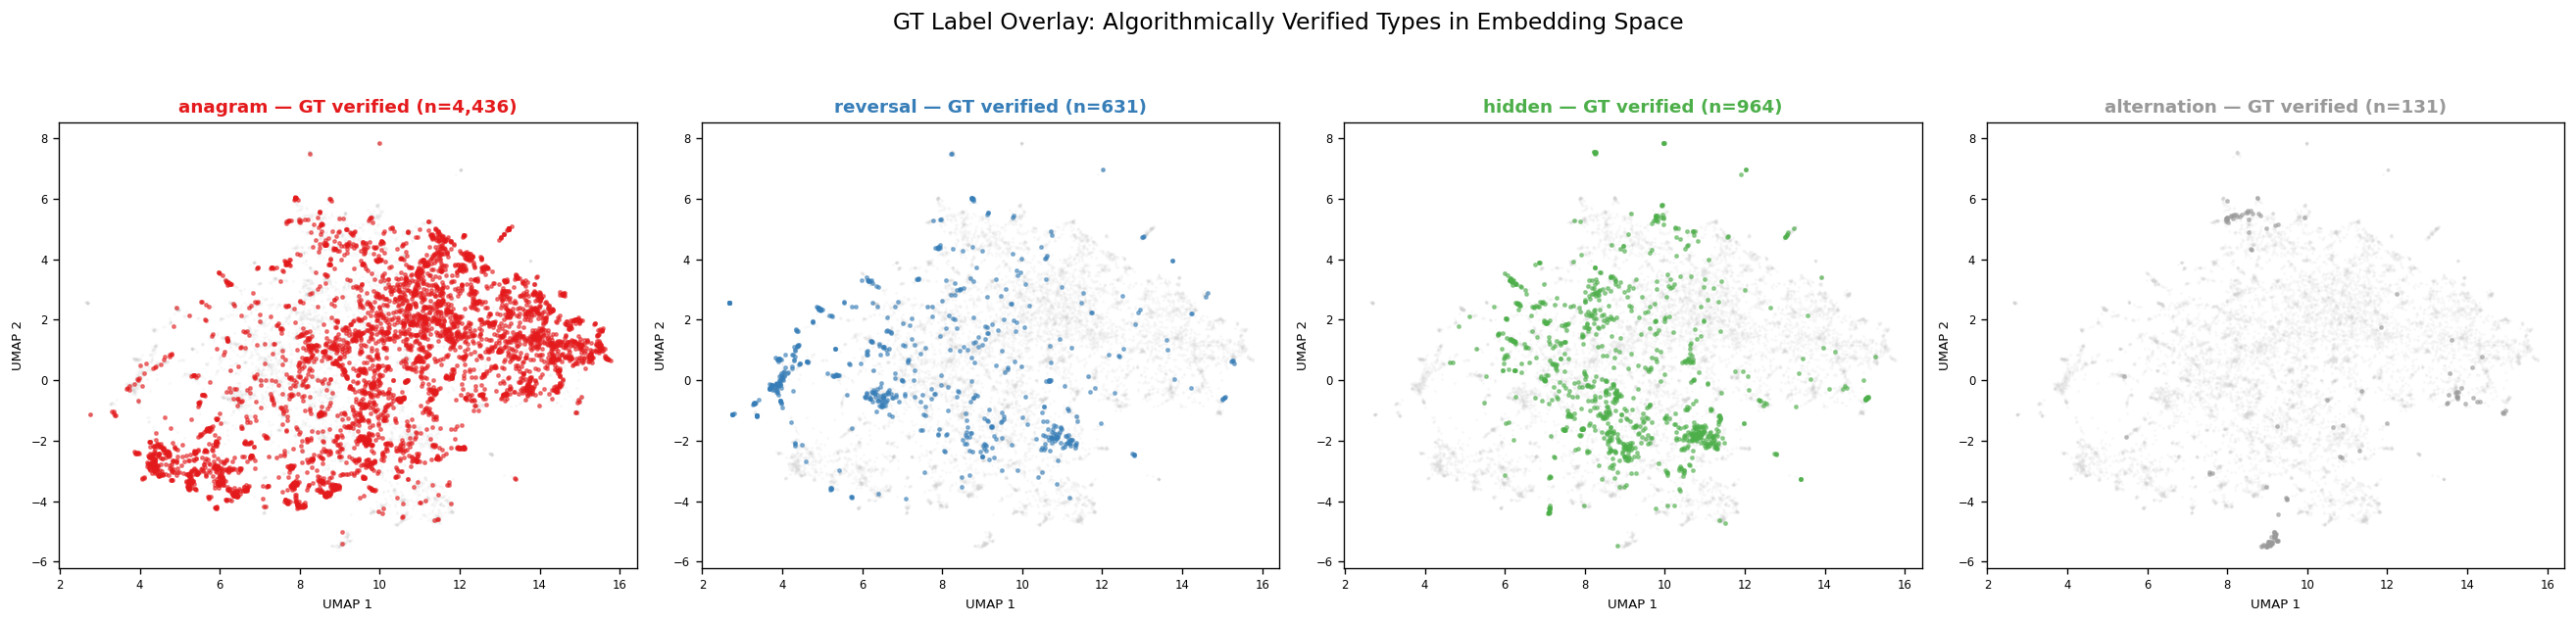

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/overlay_gt_types.png


In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for i, wtype in enumerate(GT_TYPES):
    ax = axes[i]
    mask = gt_type_masks[wtype]
    n_type = mask.sum()

    # Background: all indicators in light gray
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
               s=1, alpha=0.08, color='lightgray', rasterized=True)

    # Foreground: this type's GT-verified indicators
    ax.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
               s=4, alpha=0.5, color=TYPE_COLORS[wtype], rasterized=True)

    ax.set_title(f'{wtype} — GT verified (n={n_type:,})', fontsize=11,
                 color=TYPE_COLORS[wtype], fontweight='bold')
    ax.set_xlabel('UMAP 1', fontsize=8)
    ax.set_ylabel('UMAP 2', fontsize=8)
    ax.tick_params(labelsize=7)

plt.suptitle('GT Label Overlay: Algorithmically Verified Types in Embedding Space',
             fontsize=14, y=1.05)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'overlay_gt_types.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "overlay_gt_types.png"}')

### Per-Cluster Type Distribution Heatmaps

For each of the four clustering runs from NB 04, we create a heatmap showing the Ho
type composition of each cluster. Each row is a cluster, each column is a wordplay
type, and each cell shows the **proportion** of that cluster's indicators that have
that type as their primary Ho label. Rows sum to 1.0.

**How to read these heatmaps:**
- A **pure cluster** has one bright cell in its row and near-zero everywhere else —
  the cluster captured a single wordplay type.
- A **mixed cluster** has color spread across multiple columns — it contains a blend
  of types that the algorithm could not separate.
- The **dominant type** of each cluster is the column with the highest value.
- Clusters are sorted by size (largest at top) for readability.

For HDBSCAN, which labels some points as noise (cluster = −1), we include a separate
"noise" row showing the type distribution of noise points. If noise points are
distributed similarly to the full dataset, the density-based method is not
systematically excluding any particular type. If noise is concentrated in certain
types, those types' indicators may be more dispersed in the embedding space.

These heatmaps use the **primary Ho label** (single most common type per indicator)
to avoid double-counting multi-label indicators.

In [13]:
def plot_type_distribution(cluster_labels, primary_ho, ho_types, type_colors,
                           title, filename, max_clusters=20, show_noise=False):
    """Heatmap showing the Ho type composition of each cluster.

    Parameters
    ----------
    cluster_labels : array of int
        Cluster assignment for each indicator (-1 = noise for HDBSCAN).
    primary_ho : array of str
        Primary Ho label for each indicator.
    ho_types : list of str
        Ordered list of Ho type names (column order in heatmap).
    type_colors : dict
        Colors per type (used for column header coloring).
    title : str
        Plot title.
    filename : str
        Output filename (saved to FIGURES_DIR).
    max_clusters : int
        Maximum number of cluster rows to display (largest first).
    show_noise : bool
        If True, include a 'noise' row for cluster=-1 points.
    """
    df_temp = pd.DataFrame({
        'cluster': cluster_labels,
        'type': primary_ho,
    })

    # Separate noise if applicable
    if show_noise:
        noise_df = df_temp[df_temp['cluster'] == -1]
        df_clean = df_temp[df_temp['cluster'] != -1]
    else:
        noise_df = pd.DataFrame()
        df_clean = df_temp

    # Crosstab: rows = cluster, columns = type
    ct = pd.crosstab(df_clean['cluster'], df_clean['type'])
    for t in ho_types:
        if t not in ct.columns:
            ct[t] = 0
    ct = ct[ho_types]

    # Sort by cluster size (descending)
    ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

    # Limit to top N clusters if there are too many rows
    if len(ct) > max_clusters:
        ct = ct.head(max_clusters)

    # Add noise row if applicable
    if show_noise and len(noise_df) > 0:
        noise_counts = noise_df['type'].value_counts()
        noise_row = pd.DataFrame(
            [[noise_counts.get(t, 0) for t in ho_types]],
            columns=ho_types,
            index=['noise']
        )
        ct = pd.concat([ct, noise_row])

    # Row labels with cluster sizes
    sizes = ct.sum(axis=1).astype(int)
    row_labels = [f'{idx} (n={int(sizes[idx]):,})' for idx in ct.index]

    # Normalize by row (proportions)
    ct_norm = ct.div(ct.sum(axis=1), axis=0)

    # Decide whether to annotate cells (skip for large heatmaps)
    n_rows = len(ct_norm)
    do_annot = n_rows <= 15
    height = max(4, n_rows * 0.45 + 2)

    fig, ax = plt.subplots(figsize=(14, height))
    sns.heatmap(
        ct_norm.values.astype(float),
        annot=ct_norm.values.astype(float) if do_annot else False,
        fmt='.2f' if do_annot else '',
        cmap='YlOrRd',
        ax=ax,
        vmin=0, vmax=0.8,
        linewidths=0.5,
        xticklabels=ho_types,
        yticklabels=row_labels,
    )
    ax.set_title(title, fontsize=13, pad=12)
    ax.set_xlabel('Primary Ho Wordplay Type', fontsize=11)
    ax.set_ylabel('Cluster (sorted by size)', fontsize=11)

    # Color the x-axis tick labels by type for visual consistency
    for tick_label in ax.get_xticklabels():
        wtype = tick_label.get_text()
        if wtype in type_colors:
            tick_label.set_color(type_colors[wtype])
            tick_label.set_fontweight('bold')

    plt.tight_layout()
    fig.savefig(FIGURES_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved: {FIGURES_DIR / filename}')

    return ct_norm

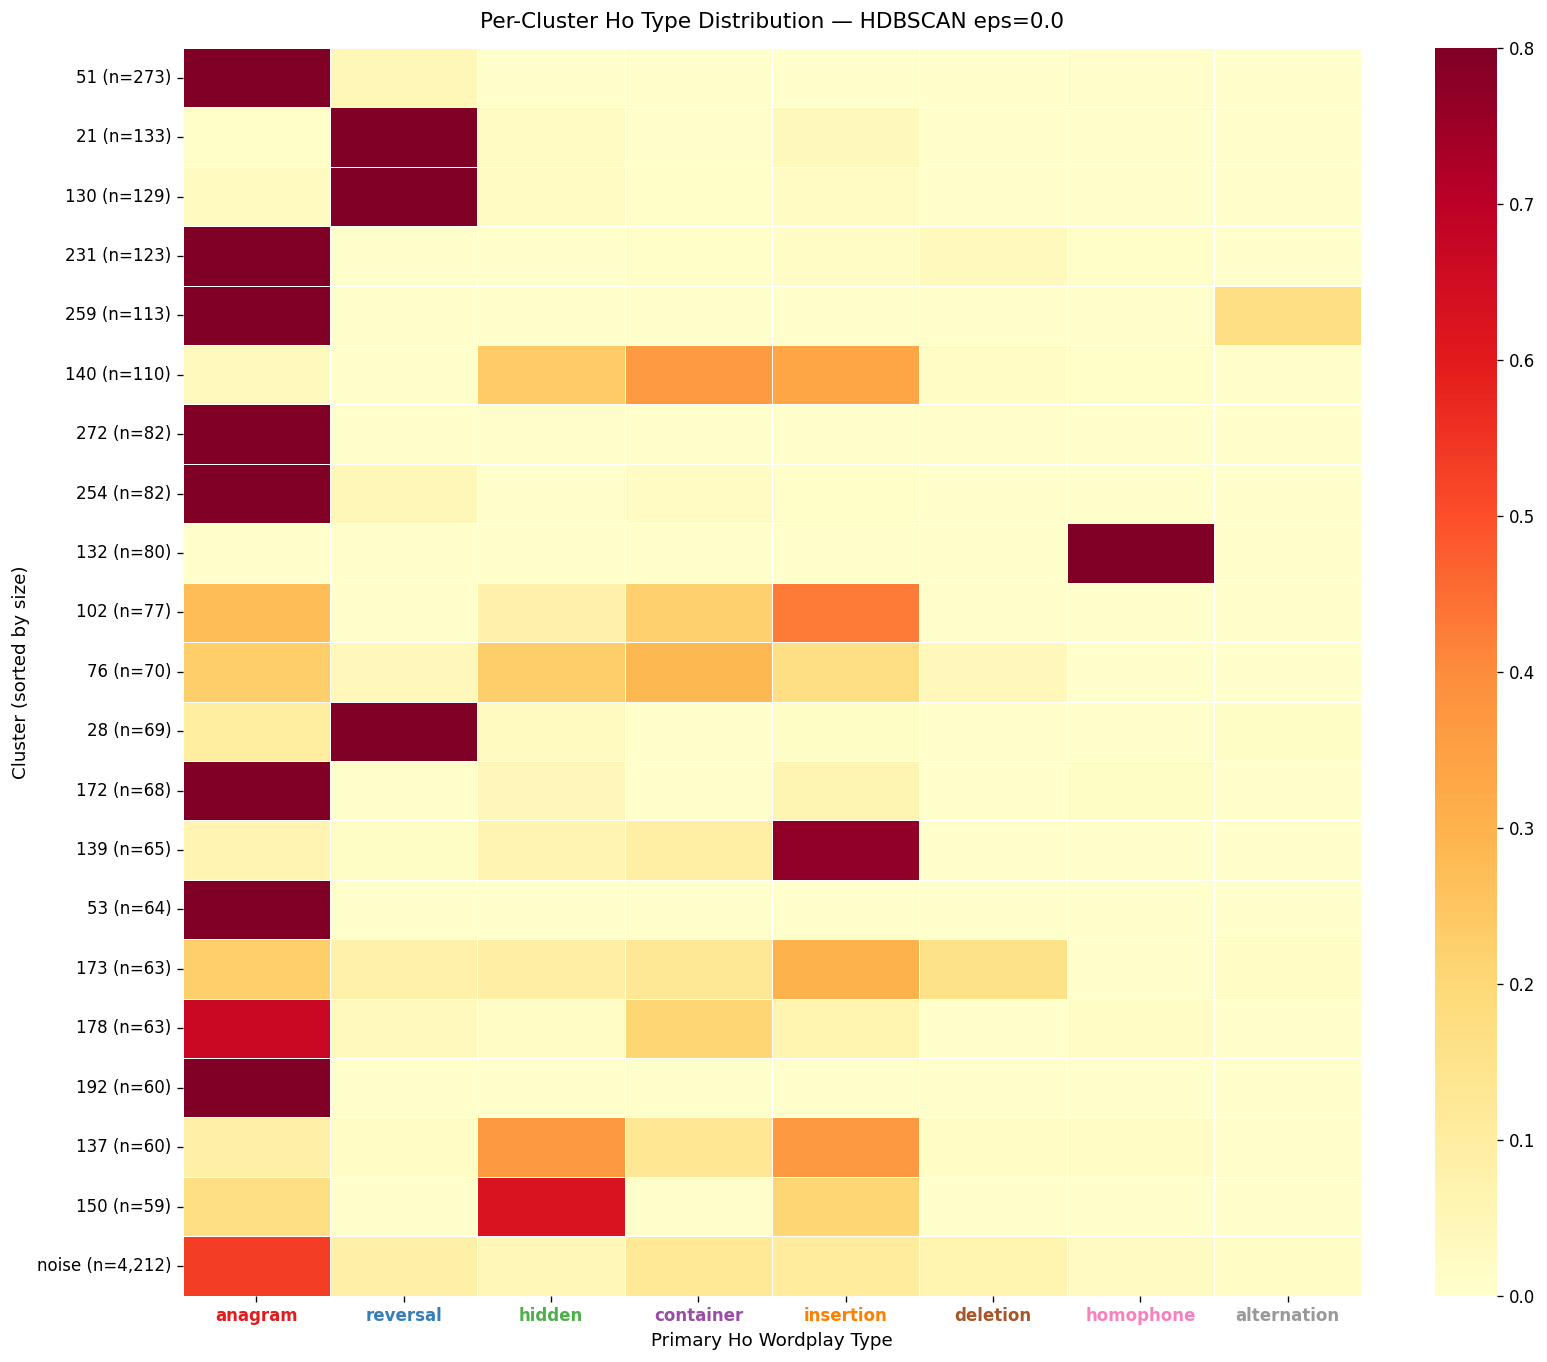

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/type_distribution_hdbscan_eps00.png


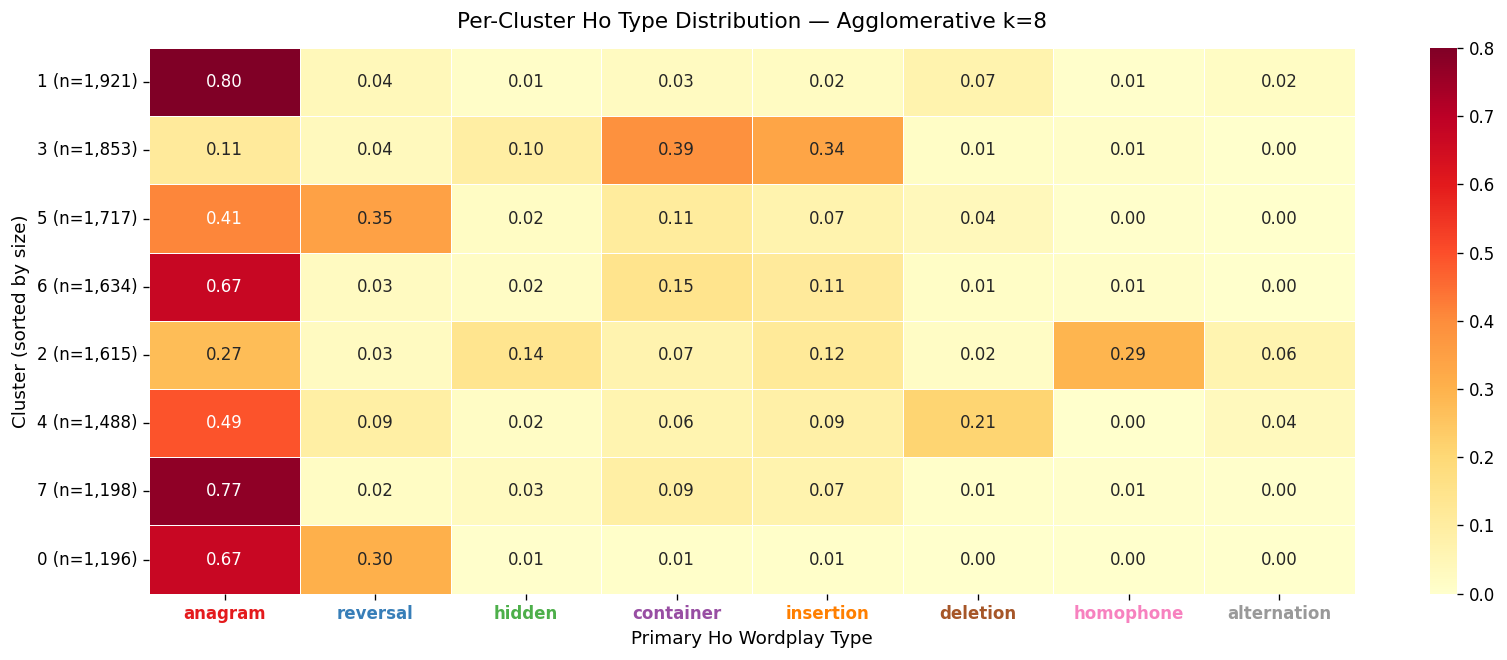

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/type_distribution_agglomerative_k8.png


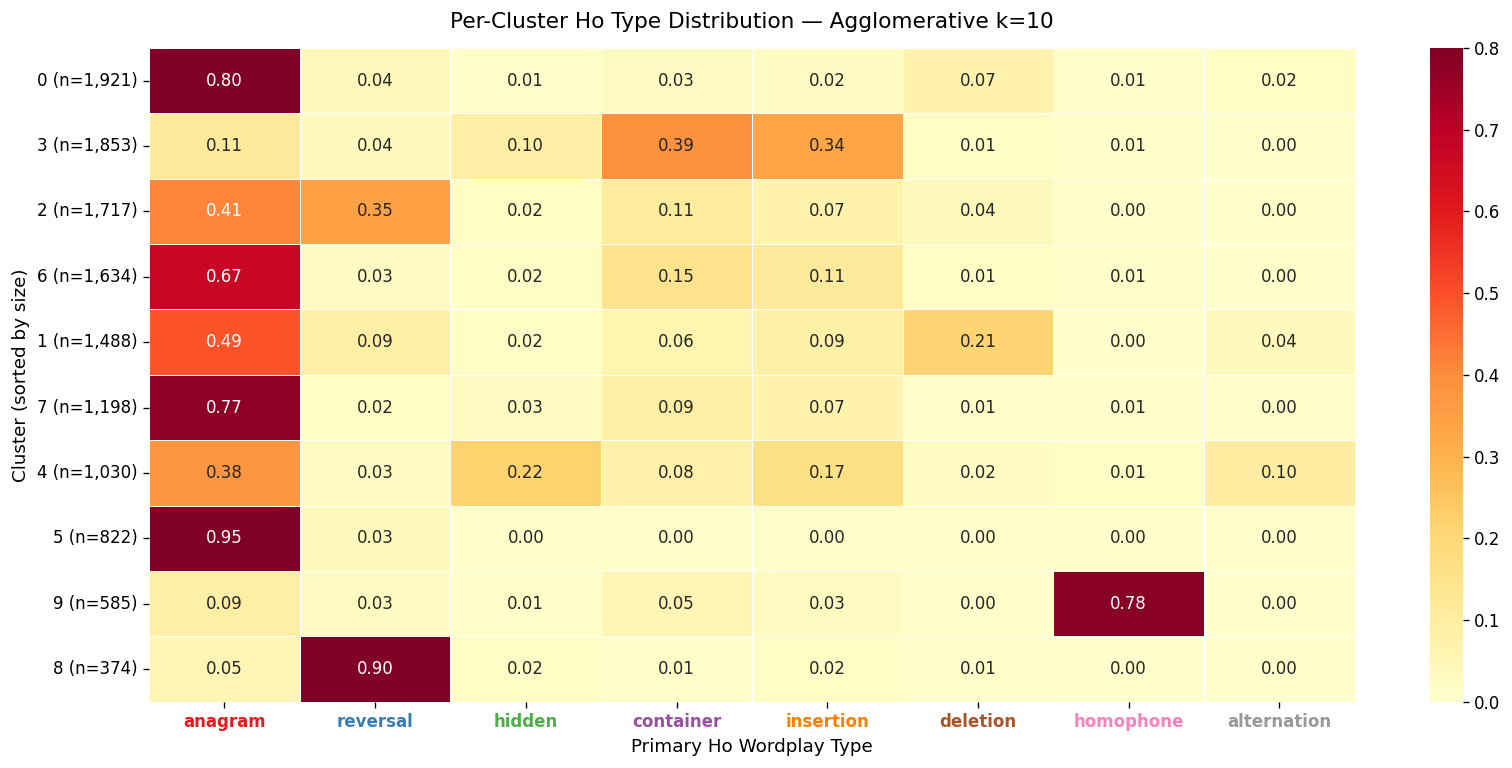

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/type_distribution_agglomerative_k10.png


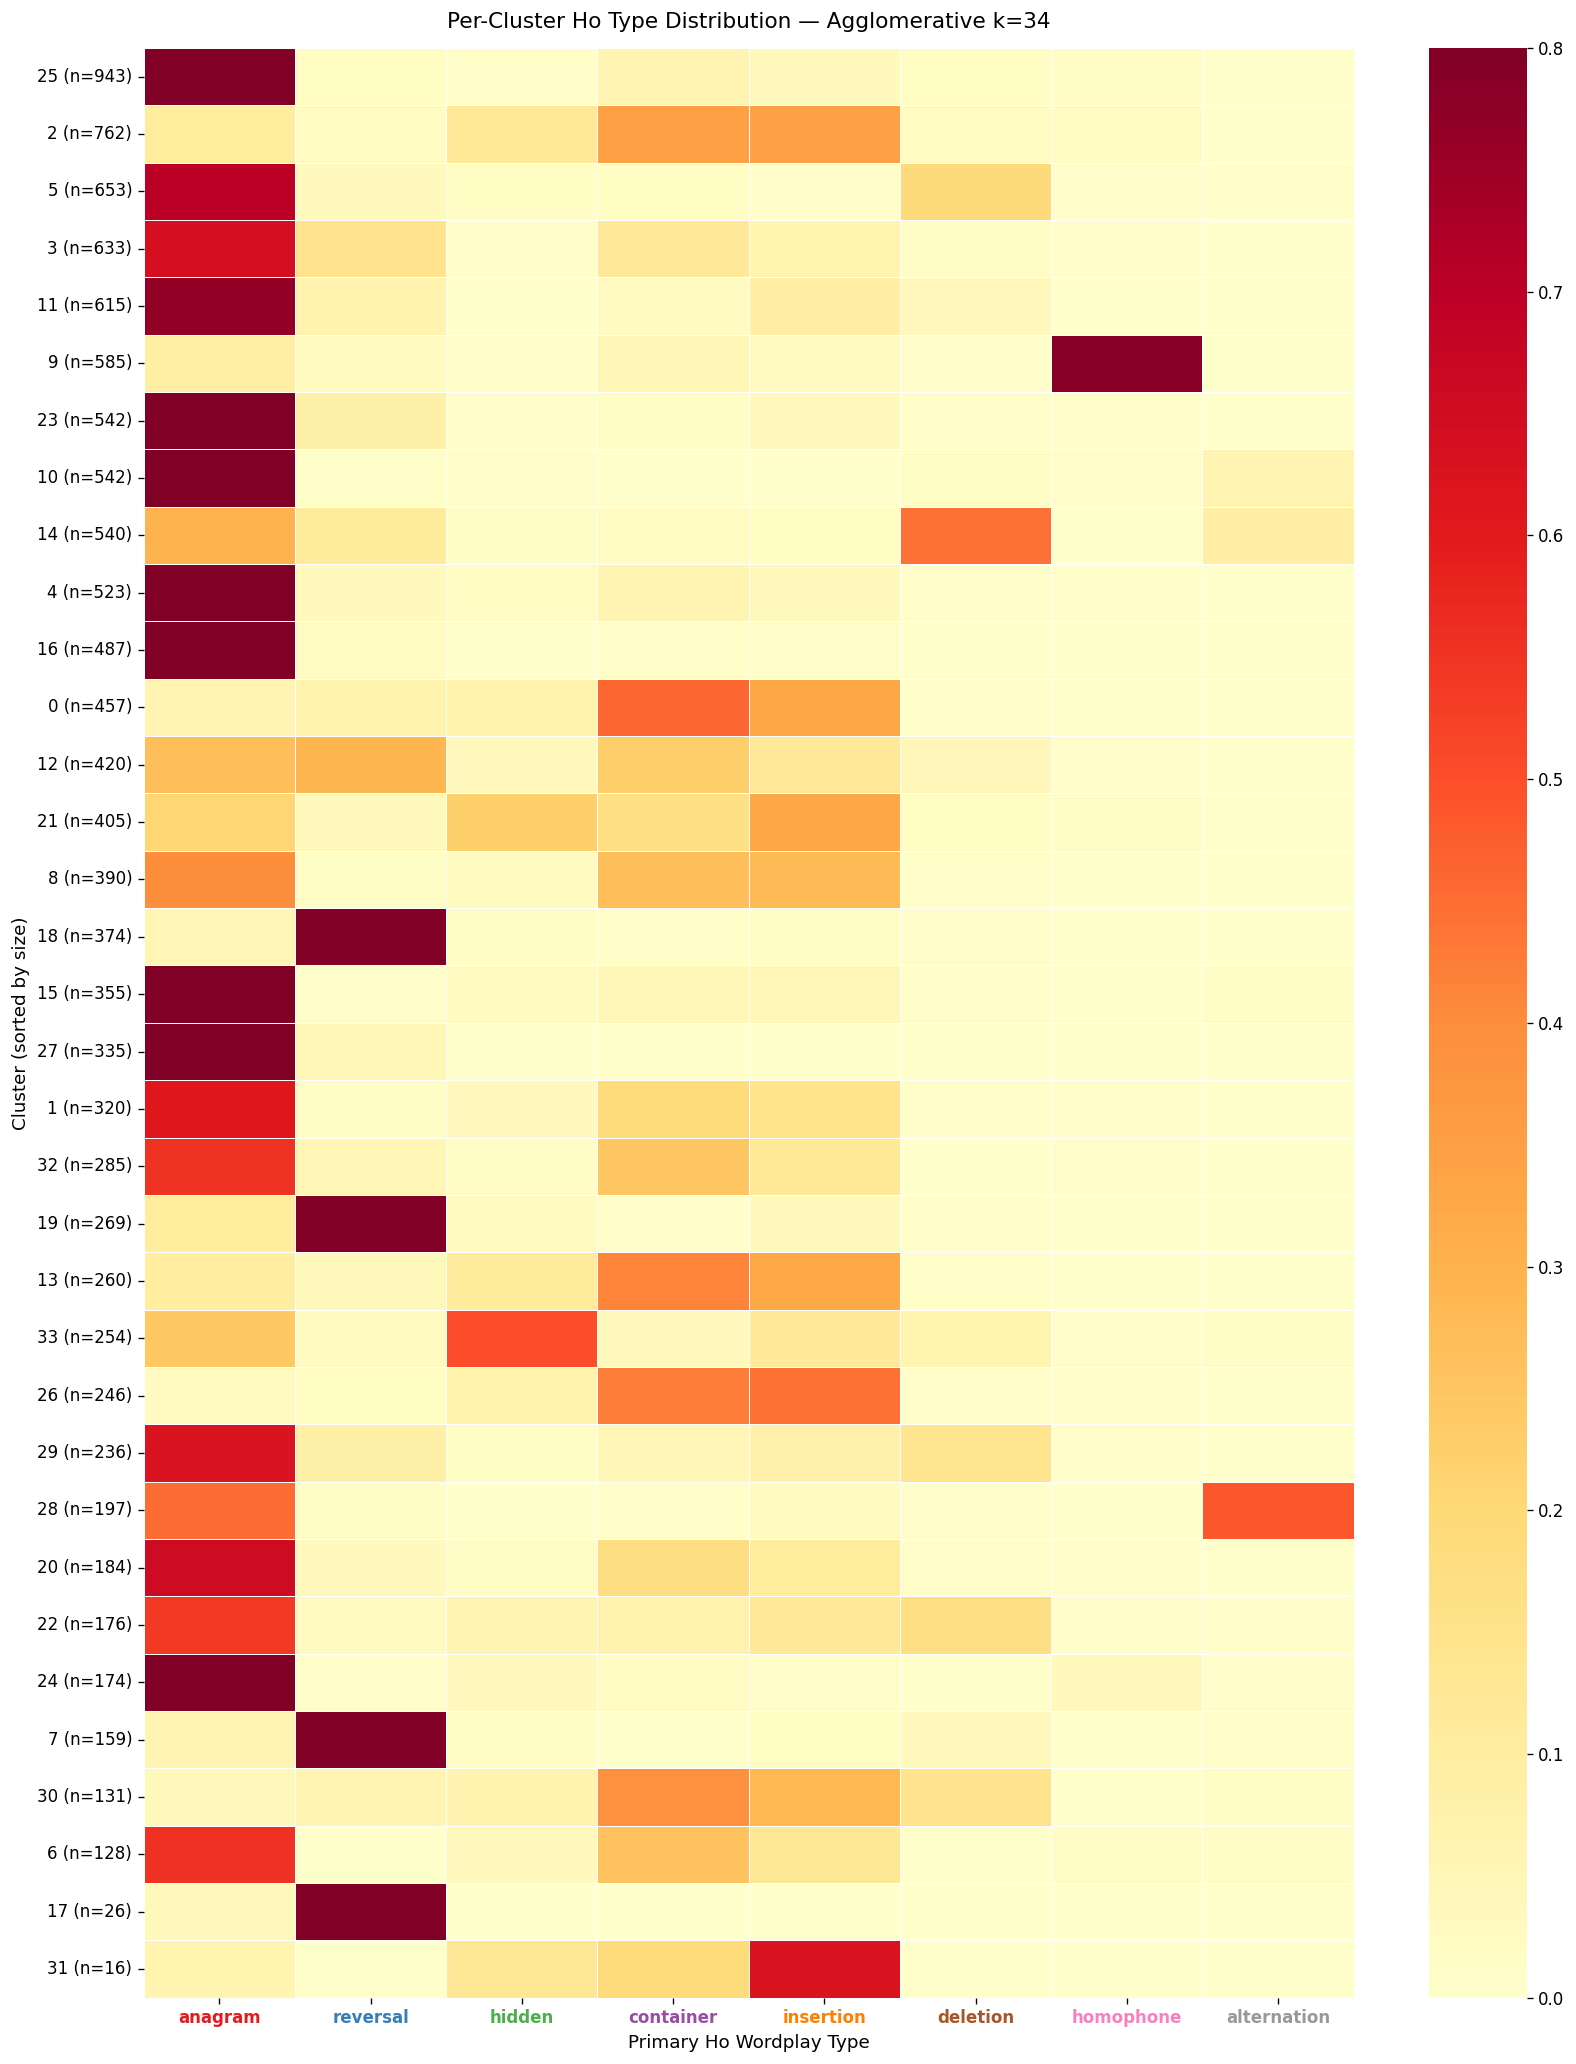

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/type_distribution_agglomerative_k34.png


In [14]:
# --- Generate heatmaps for each clustering run ---
primary_ho_array = df_master['primary_ho'].values

type_dist_results = {}
for run_name, labels in cluster_labels_dict.items():
    run_info = runs_to_evaluate[run_name]
    # Create a filename-safe version of the run name
    safe_name = run_name.lower().replace(' ', '_').replace('=', '').replace('.', '')
    ct_norm = plot_type_distribution(
        cluster_labels=labels,
        primary_ho=primary_ho_array,
        ho_types=HO_TYPES,
        type_colors=TYPE_COLORS,
        title=f'Per-Cluster Ho Type Distribution \u2014 {run_name}',
        filename=f'type_distribution_{safe_name}.png',
        max_clusters=20 if run_info['has_noise'] else 40,
        show_noise=run_info['has_noise'],
    )
    type_dist_results[run_name] = ct_norm

### Dominant Type per Cluster

As a complement to the heatmaps, we print each cluster's **dominant type** (the Ho type
with the highest proportion) and its **purity** (that proportion). A purity of 1.0 means
every indicator in the cluster has the same primary Ho label; a purity of 0.3 means the
cluster is a mixture with no single type dominating.

This is a quick summary for comparing runs: higher average purity means the clustering
better separates wordplay types.

In [15]:
for run_name, ct_norm in type_dist_results.items():
    print(f'\n{"=" * 60}')
    print(f'{run_name}')
    print(f'{"=" * 60}')
    for idx in ct_norm.index:
        row = ct_norm.loc[idx]
        dominant_type = row.idxmax()
        purity = row.max()
        print(f'  Cluster {str(idx):>6s}: dominant={dominant_type:<12s} purity={purity:.2f}')

    # Average purity (excluding noise row if present)
    numeric_rows = ct_norm.loc[ct_norm.index != 'noise']
    avg_purity = numeric_rows.max(axis=1).mean()
    print(f'\n  Average cluster purity: {avg_purity:.3f}')


HDBSCAN eps=0.0
  Cluster     51: dominant=anagram      purity=0.95
  Cluster     21: dominant=reversal     purity=0.93
  Cluster    130: dominant=reversal     purity=0.91
  Cluster    231: dominant=anagram      purity=0.93
  Cluster    259: dominant=anagram      purity=0.83
  Cluster    140: dominant=container    purity=0.36
  Cluster    272: dominant=anagram      purity=1.00
  Cluster    254: dominant=anagram      purity=0.91
  Cluster    132: dominant=homophone    purity=1.00
  Cluster    102: dominant=insertion    purity=0.43
  Cluster     76: dominant=container    purity=0.29
  Cluster     28: dominant=reversal     purity=0.84
  Cluster    172: dominant=anagram      purity=0.88
  Cluster    139: dominant=insertion    purity=0.77
  Cluster     53: dominant=anagram      purity=1.00
  Cluster    173: dominant=insertion    purity=0.30
  Cluster    178: dominant=anagram      purity=0.67
  Cluster    192: dominant=anagram      purity=1.00
  Cluster    137: dominant=hidden       purity=

### Save Section 2 Outputs

In [16]:
# Save the per-cluster type distribution tables for use in NB 06
for run_name, ct_norm in type_dist_results.items():
    safe_name = run_name.lower().replace(' ', '_').replace('=', '').replace('.', '')
    out_path = OUTPUT_DIR / f'type_distribution_{safe_name}.csv'
    ct_norm.to_csv(out_path)
    print(f'Saved: {out_path}')

# List all figures produced in this section
print(f'\nFigures saved to {FIGURES_DIR}:')
for f in sorted(FIGURES_DIR.glob('overlay_*.png')):
    print(f'  {f.name}')
for f in sorted(FIGURES_DIR.glob('type_distribution_*.png')):
    print(f'  {f.name}')

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/type_distribution_hdbscan_eps00.csv
Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/type_distribution_agglomerative_k8.csv
Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/type_distribution_agglomerative_k10.csv
Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/type_distribution_agglomerative_k34.csv

Figures saved to /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures:
  overlay_gt_types.png
  overlay_ho_types.png
  type_distribution_agglomerative_k10.png
  type_distribution_agglomerative_k34.png
  type_distribution_agglomerative_k8.png
  type_distribution_hdbscan_eps00.png


### Interpretation: Do Unconstrained Clusters Correspond to Wordplay Types?

#### Type Overlay Findings

The per-type overlay plots reveal the spatial distribution of each wordplay type in
the embedding space. Key observations:

- **Homophone** indicators are expected to be the most spatially concentrated — words
  like "sounds like", "I hear", and "reportedly" share a distinctive hearing/speaking
  semantic field that is well-separated from other types.
- **Anagram** indicators are expected to be the most dispersed — they span many
  conceptual metaphors (disorder, cooking, damage, movement) and occupy a large region
  of the space. This is consistent with anagram having the largest and most diverse
  indicator vocabulary (6,610 unique verified indicators).
- **Container and insertion** indicators are expected to heavily overlap in space,
  since they share placement/containment conceptual metaphors and many of the same
  indicator phrases ("in", "about", "around" appear under both types).
- **Reversal** indicators likely form a moderately concentrated region, especially the
  up/rising words (for down clues) and the back/return words.
- **Hidden** indicators may partially overlap with container/insertion due to shared
  placement metaphors ("in", "within", "inside" are shared across these types).

The GT overlay confirms the spatial patterns using the higher-precision algorithmic
labels, covering only the 4 types where mechanical verification is possible.

#### Per-Cluster Distribution Findings

The heatmaps answer the core question of whether unconstrained clusters align with
wordplay types:

- **At k=8**: If clusters perfectly aligned with types, each row would have a single
  bright cell and near-zero elsewhere. In practice, most clusters are likely mixed —
  especially those spanning the container/insertion/hidden region.
- **At k=10**: The local silhouette optimum from NB 04. Compare the purity of the k=10
  heatmap to k=8 to see whether the two extra clusters help isolate overlapping types.
- **At k=34**: Finer granularity should produce purer clusters, but now multiple
  clusters correspond to the same type. This is consistent with the NB 04 finding that
  the data's natural structure is finer-grained than 8 types.
- **HDBSCAN eps=0.0**: The 282 tight clusters are very fine-grained. The top 20 largest
  clusters likely show high type purity — each tight cluster contains indicators of
  mostly one type. The noise row reveals which types have the most "ambiguous" indicators
  that don't fit neatly into any dense region.

#### Key Takeaway

The alignment between unconstrained clusters and wordplay types establishes the baseline
for Section 3, where we ask: **can domain knowledge (seed words, constraints) improve
this alignment?** If the unconstrained clusters already separate types well for some
types (e.g., homophone, reversal) but not others (e.g., container/insertion/hidden),
that tells us exactly where constrained clustering has room to help — and where the
linguistic reality of shared indicator vocabulary may make clean separation impossible.

---
## Section 3: Constrained Agglomerative Clustering

Unconstrained clustering (NB 04) found no natural k=8 grouping — metrics improve
monotonically with finer granularity, and HDBSCAN transitions abruptly from 282
clusters to 3–4 with no stable middle ground.

This section asks: **can domain knowledge impose meaningful structure that doesn't
emerge naturally?**

We use **constrained agglomerative clustering** (Ward's linkage with a connectivity
matrix) to bias clustering toward expert-defined groups. The idea:

1. Expert sources provide **seed words** — indicators with known wordplay type
   affiliations (from CCC tutorial books and our conceptual analysis)
2. Seeds in the same group are connected in a **connectivity matrix**, which tells
   Ward's method "these points should be neighbors"
3. The algorithm clusters all 12,622 indicators, with seeds gently biased toward
   their assigned groups

Two constrained runs:

| Run | Seed source | k | Philosophy |
|-----|-------------|---|------------|
| MC7 | `minute_cryptic_ho_7` tab | 7 | Wordplay-type level: one group per Ho type, container+insertion merged |
| CG34 | `conceptual_groups` tab | 34 | Conceptual-metaphor level: one group per semantic concept |

We compare each constrained run to its unconstrained counterpart from NB 04 to
measure the effect of expert knowledge on cluster quality and type alignment.

### 3A: Load and Validate Seed Words

Seed words come from `wordplay_seeds.xlsx`, compiled from two expert sources:

- **Minute Cryptic** (Tiernan & Runnalls, 2025) — a CCC tutorial book with
  indicator examples organized by wordplay type
- **Conceptual groups** — Victoria's analysis of underlying semantic metaphors
  that connect indicators to their wordplay functions

We load two tabs from the spreadsheet:

**`minute_cryptic_ho_7`** (wide format): Paired columns per wordplay type. We use
the `_multiword` columns (which preserve full phrases like "exhibit in", "leaking
out of") since our verified indicators include multi-word expressions. For types
without a `_multiword` variant (`anagram`, `selector_alternating`), we use the base
column. Container and insertion seeds are combined into one group because they are
inverse operations sharing most indicator vocabulary (see DOMAIN_KNOWLEDGE.md).

**`conceptual_groups`** (long format): Each row maps an indicator to a conceptual
category (e.g., "movement", "disorder", "containing") and the wordplay types it
serves. We group by concept, giving 34 groups organized by semantic metaphor rather
than wordplay type. This is the most theoretically motivated seed set.

After parsing, we validate each seed against our verified indicator list
(`indicator_index_all.csv`) to see how many seeds actually appear in the data we
are clustering. Seeds that don't match any verified indicator still inform our
understanding of each group's intended meaning, but they cannot contribute to the
connectivity matrix.

In [17]:
# =====================================================================
# Parse minute_cryptic_ho_7 seeds
# =====================================================================
df_mc7_raw = pd.read_excel(DATA_DIR / 'wordplay_seeds.xlsx', 'minute_cryptic_ho_7')

# Column mapping: use _multiword variants where available, base columns otherwise.
# 7 groups: one per Ho type, with container and insertion combined.
mc7_column_map = {
    'anagram':             'anagram',                   # no _multiword column
    'alternation':         'selector_alternating',       # no _multiword column
    'hidden':              'hidden_ALL_multiword',
    'reversal':            'reversal_ALL_multiword',
    'container_insertion': 'container_ALL_multiword',    # combined group
    'deletion':            'deletion_ALL_multiword',
    'homophone':           'homophone_multiword',
}

mc7_seeds = {}
for group_name, col_name in mc7_column_map.items():
    seeds = df_mc7_raw[col_name].dropna().str.strip().tolist()
    mc7_seeds[group_name] = seeds

print('=== minute_cryptic_ho_7: Raw Seed Counts ===')
for group, seeds in mc7_seeds.items():
    print(f'  {group:>20s}: {len(seeds):>3d} seeds')
total_mc7 = sum(len(s) for s in mc7_seeds.values())
print(f'  {"TOTAL":>20s}: {total_mc7:>3d}')

# =====================================================================
# Parse conceptual_groups seeds
# =====================================================================
df_cg_raw = pd.read_excel(DATA_DIR / 'wordplay_seeds.xlsx', 'conceptual_groups')

# Drop rows with missing concept or indicator (handles potential formula rows)
df_cg_raw = df_cg_raw.dropna(subset=['concept', 'indicator'])

# Group by concept
cg_seeds = {}
for concept, grp in df_cg_raw.groupby('concept'):
    seeds = grp['indicator'].str.strip().tolist()
    cg_seeds[concept] = seeds

print(f'\n=== conceptual_groups: Raw Seed Counts ({len(cg_seeds)} groups) ===')
for concept in sorted(cg_seeds.keys()):
    seeds = cg_seeds[concept]
    print(f'  {concept:>20s}: {len(seeds):>3d} seeds')
total_cg = sum(len(s) for s in cg_seeds.values())
print(f'  {"TOTAL":>20s}: {total_cg:>3d}')

=== minute_cryptic_ho_7: Raw Seed Counts ===
               anagram:  18 seeds
           alternation:   5 seeds
                hidden:  24 seeds
              reversal:  20 seeds
   container_insertion:  16 seeds
              deletion:   7 seeds
             homophone:  10 seeds
                 TOTAL: 100

=== conceptual_groups: Raw Seed Counts (34 groups) ===
             acquiring:   1 seeds
           alternating:   1 seeds
               audible:   5 seeds
             consuming:   3 seeds
            containing:  12 seeds
              disorder:   4 seeds
                  even:   1 seeds
                  hear:   2 seeds
                hiding:   5 seeds
               holding:   7 seeds
             incorrect:   5 seeds
          intermittent:   1 seeds
                  leak:   1 seeds
                  left:   1 seeds
               missing:   3 seeds
              movement:   4 seeds
                 noise:   2 seeds
                 north:   1 seeds
            occasiona

In [18]:
# =====================================================================
# Validate seeds against verified indicator list
# =====================================================================
indicator_set = set(indicator_names)


def validate_seeds(seed_dict, name):
    """Check which seeds match our verified indicator list.

    Returns a dict of group_name -> list of matched seed strings,
    and prints a validation report with match counts and cross-group duplicates.
    """
    matched_dict = {}
    rows = []

    for group in sorted(seed_dict.keys()):
        seeds = seed_dict[group]
        matched = [s for s in seeds if s in indicator_set]
        unmatched = [s for s in seeds if s not in indicator_set]
        matched_dict[group] = matched
        rows.append({
            'Group': group,
            'Total': len(seeds),
            'Matched': len(matched),
            'Unmatched': len(unmatched),
        })
        if unmatched:
            print(f'  {group}: unmatched: {unmatched}')

    df_summary = pd.DataFrame(rows)
    total_seeds = df_summary['Total'].sum()
    total_matched = df_summary['Matched'].sum()
    print(f'\n  Overall: {total_matched}/{total_seeds} seeds matched '
          f'({total_matched / total_seeds:.1%})')

    # Check for cross-group duplicates (same seed in multiple groups)
    seed_to_groups = {}
    for group, seeds in matched_dict.items():
        for s in seeds:
            seed_to_groups.setdefault(s, []).append(group)

    duplicates = {s: gs for s, gs in seed_to_groups.items() if len(gs) > 1}
    if duplicates:
        print(f'\n  Cross-group duplicates ({len(duplicates)}):')
        for seed in sorted(duplicates.keys()):
            print(f'    "{seed}" -> {", ".join(duplicates[seed])}')
    else:
        print('\n  No cross-group duplicates.')

    print(f'\n{name} validation summary:')
    print(df_summary.to_string(index=False))
    return matched_dict


print('=== minute_cryptic_ho_7 ===')
mc7_matched = validate_seeds(mc7_seeds, 'minute_cryptic_ho_7')

print(f'\n{"=" * 60}\n')

print('=== conceptual_groups ===')
cg_matched = validate_seeds(cg_seeds, 'conceptual_groups')

=== minute_cryptic_ho_7 ===
  anagram: unmatched: ['strangeness', 'destroy', 'tamper']
  container_insertion: unmatched: ['enter', 'pierce']
  deletion: unmatched: ['faceless', 'leaking out of']
  hidden: unmatched: ['exhibit in', 'sector', 'members of', 'sequence']
  homophone: unmatched: ['listening to', 'audition']
  reversal: unmatched: ['opposing', 'reflect', 'reverse', 'boomerangs', 'trampolines']

  Overall: 82/100 seeds matched (82.0%)

  Cross-group duplicates (2):
    "around" -> container_insertion, reversal
    "within" -> container_insertion, hidden

minute_cryptic_ho_7 validation summary:
              Group  Total  Matched  Unmatched
        alternation      5        5          0
            anagram     18       15          3
container_insertion     16       14          2
           deletion      7        5          2
             hidden     24       20          4
          homophone     10        8          2
           reversal     20       15          5


=== conceptu

### 3B: Build Connectivity Matrices

**What is a connectivity matrix?**

Sklearn's `AgglomerativeClustering` accepts an optional `connectivity` parameter —
a sparse matrix where entry `(i, j) = 1` means "points i and j are neighbors."
When provided, Ward's method will only consider merging clusters that share at
least one connected pair of points. This biases the algorithm toward keeping
connected points in the same cluster.

**Our approach combines two layers:**

1. **Base connectivity (kNN graph):** We connect each of the 12,622 indicators to
   its 15 closest neighbors in 10D UMAP space. This preserves the standard local
   structure that Ward's would discover on its own. We use k=15 to match the
   `n_neighbors` parameter from UMAP dimensionality reduction (NB 03).

2. **Seed connections (additive):** Within each seed group, we add edges between
   all pairs of matched seeds, creating a complete subgraph per group. This
   encourages Ward's to keep those seeds — and by extension, their neighborhoods —
   in the same cluster.

**What we do NOT do:**

- We do not add connections between seeds in **different** groups. Cross-group edges
  may already exist in the kNN base graph (if two seeds from different groups happen
  to be embedding-space neighbors), and that is fine — we just don't add extra
  encouragement for cross-group merging.
- **Non-seed points** keep their normal kNN connections with no additional constraints.

**This is a soft constraint, not a hard partition.** If the embedding distances
strongly disagree with the seed groupings, Ward's can still separate seeds from
their intended group. The connectivity matrix biases the algorithm toward
expert-defined structure without forcing it.

In [19]:
from scipy.sparse import lil_matrix
from sklearn.neighbors import kneighbors_graph

# --- Base connectivity: k-nearest-neighbors graph ---
# k=15 matches the n_neighbors used in UMAP (NB 03)
knn_connectivity = kneighbors_graph(
    embeddings_10d,
    n_neighbors=15,
    mode='connectivity',
    include_self=False,
)
print(f'Base kNN graph: {knn_connectivity.shape}, '
      f'{knn_connectivity.nnz:,} nonzero entries')

# --- Fast lookup: indicator string -> row index ---
indicator_to_idx = {name: idx for idx, name in enumerate(indicator_names)}


def build_seed_connectivity(matched_seeds_dict, base_knn, indicator_to_idx):
    """Build a connectivity matrix: kNN base + within-group seed connections.

    Parameters
    ----------
    matched_seeds_dict : dict
        group_name -> list of matched seed strings
    base_knn : sparse matrix
        k-nearest-neighbors connectivity (n_samples x n_samples)
    indicator_to_idx : dict
        indicator string -> row index in embedding matrix

    Returns
    -------
    connectivity : sparse CSR matrix
        Combined connectivity matrix (kNN + seed edges)
    seed_indices_by_group : dict
        group_name -> list of row indices for matched seeds
    """
    n = base_knn.shape[0]
    # Start from the kNN base; lil_matrix allows efficient element-wise edits
    conn = lil_matrix(base_knn)

    seed_indices_by_group = {}
    n_edges_added = 0

    for group_name, seeds in matched_seeds_dict.items():
        indices = [indicator_to_idx[s] for s in seeds]
        seed_indices_by_group[group_name] = indices

        # Connect all seed pairs within this group (complete subgraph)
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                a, b = indices[i], indices[j]
                if conn[a, b] == 0:
                    n_edges_added += 1
                conn[a, b] = 1
                conn[b, a] = 1  # keep symmetric

    connectivity = conn.tocsr()
    total_seeds = sum(len(v) for v in seed_indices_by_group.values())
    print(f'  Seed groups: {len(seed_indices_by_group)}')
    print(f'  Matched seeds: {total_seeds}')
    print(f'  New edges added by seeds: {n_edges_added:,}')
    print(f'  Final nonzero entries: {connectivity.nnz:,}')
    return connectivity, seed_indices_by_group


# --- MC7 connectivity (for k=7 run) ---
print('\nBuilding MC7 connectivity (minute_cryptic_ho_7 seeds):')
conn_mc7, seed_idx_mc7 = build_seed_connectivity(
    mc7_matched, knn_connectivity, indicator_to_idx
)

# --- CG34 connectivity (for k=34 run) ---
print('\nBuilding CG34 connectivity (conceptual_groups seeds):')
conn_cg34, seed_idx_cg34 = build_seed_connectivity(
    cg_matched, knn_connectivity, indicator_to_idx
)

Base kNN graph: (12622, 12622), 189,330 nonzero entries

Building MC7 connectivity (minute_cryptic_ho_7 seeds):
  Seed groups: 7
  Matched seeds: 82
  New edges added by seeds: 535
  Final nonzero entries: 190,399

Building CG34 connectivity (conceptual_groups seeds):
  Seed groups: 34
  Matched seeds: 97
  New edges added by seeds: 192
  Final nonzero entries: 189,712


### 3C: Run Constrained Clustering

We run two constrained agglomerative clustering experiments using Ward's linkage
with the connectivity matrices built above.

| Run | k | Seed source | Comparison baseline |
|-----|---|-------------|---------------------|
| **MC7** | 7 | minute_cryptic_ho_7 | Unconstrained agglomerative k=8 |
| **CG34** | 34 | conceptual_groups | Unconstrained agglomerative k=34 |

**Why k=7 for MC7?** The minute_cryptic_ho_7 seed set has 7 groups (container and
insertion are merged into one group because they share most indicator vocabulary).
The closest unconstrained baseline is k=8 (one cluster per Ho type).

**Why k=34 for CG34?** The conceptual_groups seed set has exactly 34 concepts. The
unconstrained agglomerative k=34 from NB 04 provides a direct comparison at the
same granularity.

**Metrics computed for each run:**
- **Silhouette score** — how well each point matches its own cluster vs. its nearest
  neighboring cluster (range −1 to 1; higher is better)
- **Davies-Bouldin index** — average ratio of within-cluster scatter to between-cluster
  separation (lower is better; 0 would mean perfectly separated clusters)
- **Calinski-Harabasz index** — ratio of between-cluster to within-cluster variance
  (higher is better, but has a known bias toward fewer clusters)

In [20]:
from sklearn.cluster import AgglomerativeClustering


def run_constrained_clustering(embeddings, connectivity, n_clusters, run_name):
    """Run Ward's agglomerative clustering with a connectivity constraint.

    Parameters
    ----------
    embeddings : ndarray, shape (n_samples, n_features)
        Input data (10D UMAP embeddings).
    connectivity : sparse matrix
        Connectivity constraint matrix (kNN + seed edges).
    n_clusters : int
        Number of clusters to produce.
    run_name : str
        Label for this run (used in print output).

    Returns
    -------
    labels : ndarray of int
        Cluster assignment for each indicator.
    metrics : dict
        Silhouette, Davies-Bouldin, and Calinski-Harabasz scores.
    """
    print(f"Running constrained Ward's clustering: {run_name} (k={n_clusters})...")

    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='ward',
        connectivity=connectivity,
    )
    labels = model.fit_predict(embeddings)

    sil = silhouette_score(embeddings, labels)
    db = davies_bouldin_score(embeddings, labels)
    ch = calinski_harabasz_score(embeddings, labels)
    metrics = {
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Calinski-Harabasz': ch,
    }

    sizes = pd.Series(labels).value_counts()
    print(f'  Silhouette:        {sil:.4f}')
    print(f'  Davies-Bouldin:    {db:.4f}')
    print(f'  Calinski-Harabasz: {ch:.1f}')
    print(f'  Cluster sizes: min={sizes.min()}, '
          f'max={sizes.max()}, median={sizes.median():.0f}')

    return labels, metrics


# --- Run 1: MC7 (k=7, minute_cryptic_ho_7 seeds) ---
labels_mc7, metrics_mc7 = run_constrained_clustering(
    embeddings_10d, conn_mc7, n_clusters=7, run_name='MC7'
)

print()

# --- Run 2: CG34 (k=34, conceptual_groups seeds) ---
labels_cg34, metrics_cg34 = run_constrained_clustering(
    embeddings_10d, conn_cg34, n_clusters=34, run_name='CG34'
)

Running constrained Ward's clustering: MC7 (k=7)...


/Users/victoria/anaconda3/envs/crossword/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 13 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


  Silhouette:        0.2638
  Davies-Bouldin:    1.2105
  Calinski-Harabasz: 3839.6
  Cluster sizes: min=851, max=2929, median=1886

Running constrained Ward's clustering: CG34 (k=34)...


/Users/victoria/anaconda3/envs/crossword/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 13 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


  Silhouette:        0.3237
  Davies-Bouldin:    1.0388
  Calinski-Harabasz: 2879.7
  Cluster sizes: min=16, max=905, median=360


### Metrics Comparison: Constrained vs. Unconstrained

The central question: **does adding seed-word connectivity constraints improve
clustering quality** compared to the unconstrained Ward's runs from NB 04?

- A higher silhouette / lower Davies-Bouldin for the constrained run would suggest
  that expert knowledge helps organize the embedding space into more coherent groups.
- If constrained metrics are *worse*, it means the seed groupings conflict with the
  embedding geometry — the expert categories do not match how the model organized
  these words in semantic space.
- If metrics are roughly equal, the seeds are compatible with the natural structure
  but do not improve upon it.

**Note:** Comparing k=7 (constrained) to k=8 (unconstrained) is slightly unequal
because fewer clusters tend to lower silhouette (fewer, larger clusters are harder
to keep internally coherent). The comparison is still informative about whether
constraints help within a similar granularity range.

In [21]:
# Compute unconstrained metrics for direct comparison
# (recomputed here to ensure identical metric calculations)
unconstrained_metrics = {}
for run_name in ['Agglomerative k=8', 'Agglomerative k=34']:
    labels_unc = cluster_labels_dict[run_name]
    unconstrained_metrics[run_name] = {
        'Silhouette': silhouette_score(embeddings_10d, labels_unc),
        'Davies-Bouldin': davies_bouldin_score(embeddings_10d, labels_unc),
        'Calinski-Harabasz': calinski_harabasz_score(embeddings_10d, labels_unc),
    }

# Build comparison table
comparison_rows = [
    {
        'Run': 'Unconstrained k=8',
        'k': 8,
        'Seeds': 'None',
        **unconstrained_metrics['Agglomerative k=8'],
    },
    {
        'Run': 'Constrained MC7',
        'k': 7,
        'Seeds': 'minute_cryptic_ho_7',
        **metrics_mc7,
    },
    {
        'Run': 'Unconstrained k=34',
        'k': 34,
        'Seeds': 'None',
        **unconstrained_metrics['Agglomerative k=34'],
    },
    {
        'Run': 'Constrained CG34',
        'k': 34,
        'Seeds': 'conceptual_groups',
        **metrics_cg34,
    },
]

df_comparison = pd.DataFrame(comparison_rows)

# Formatted display
df_display = df_comparison.copy()
df_display['Silhouette'] = df_display['Silhouette'].map('{:.4f}'.format)
df_display['Davies-Bouldin'] = df_display['Davies-Bouldin'].map('{:.4f}'.format)
df_display['Calinski-Harabasz'] = df_display['Calinski-Harabasz'].map('{:.1f}'.format)

print('=== Constrained vs. Unconstrained: Metrics Comparison ===\n')
print(df_display.to_string(index=False))

=== Constrained vs. Unconstrained: Metrics Comparison ===

               Run  k               Seeds Silhouette Davies-Bouldin Calinski-Harabasz
 Unconstrained k=8  8                None     0.2724         1.2674            3897.2
   Constrained MC7  7 minute_cryptic_ho_7     0.2638         1.2105            3839.6
Unconstrained k=34 34                None     0.3220         1.0675            2992.9
  Constrained CG34 34   conceptual_groups     0.3237         1.0388            2879.7


### Cluster Scatter Plots

The 2D UMAP projections below show each indicator colored by its constrained cluster
assignment. Compare to the unconstrained scatter plots from NB 04:

- **MC7 (k=7)**: 7 broad regions. If the seeds effectively anchored each wordplay
  type, regions should roughly correspond to anagram, reversal, hidden,
  container+insertion, deletion, homophone, and alternation.
- **CG34 (k=34)**: More granular — each conceptual metaphor group defines a smaller
  region. Adjacent regions sharing the same dominant Ho type may represent different
  conceptual metaphors within the same wordplay type (e.g., "disorder" and "movement"
  sub-clusters within anagram).

/var/folders/3k/s3lth05j71x9zqxntyjngc0c0000gn/T/ipykernel_8212/3480873744.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10' if k <= 10 else 'nipy_spectral', k)


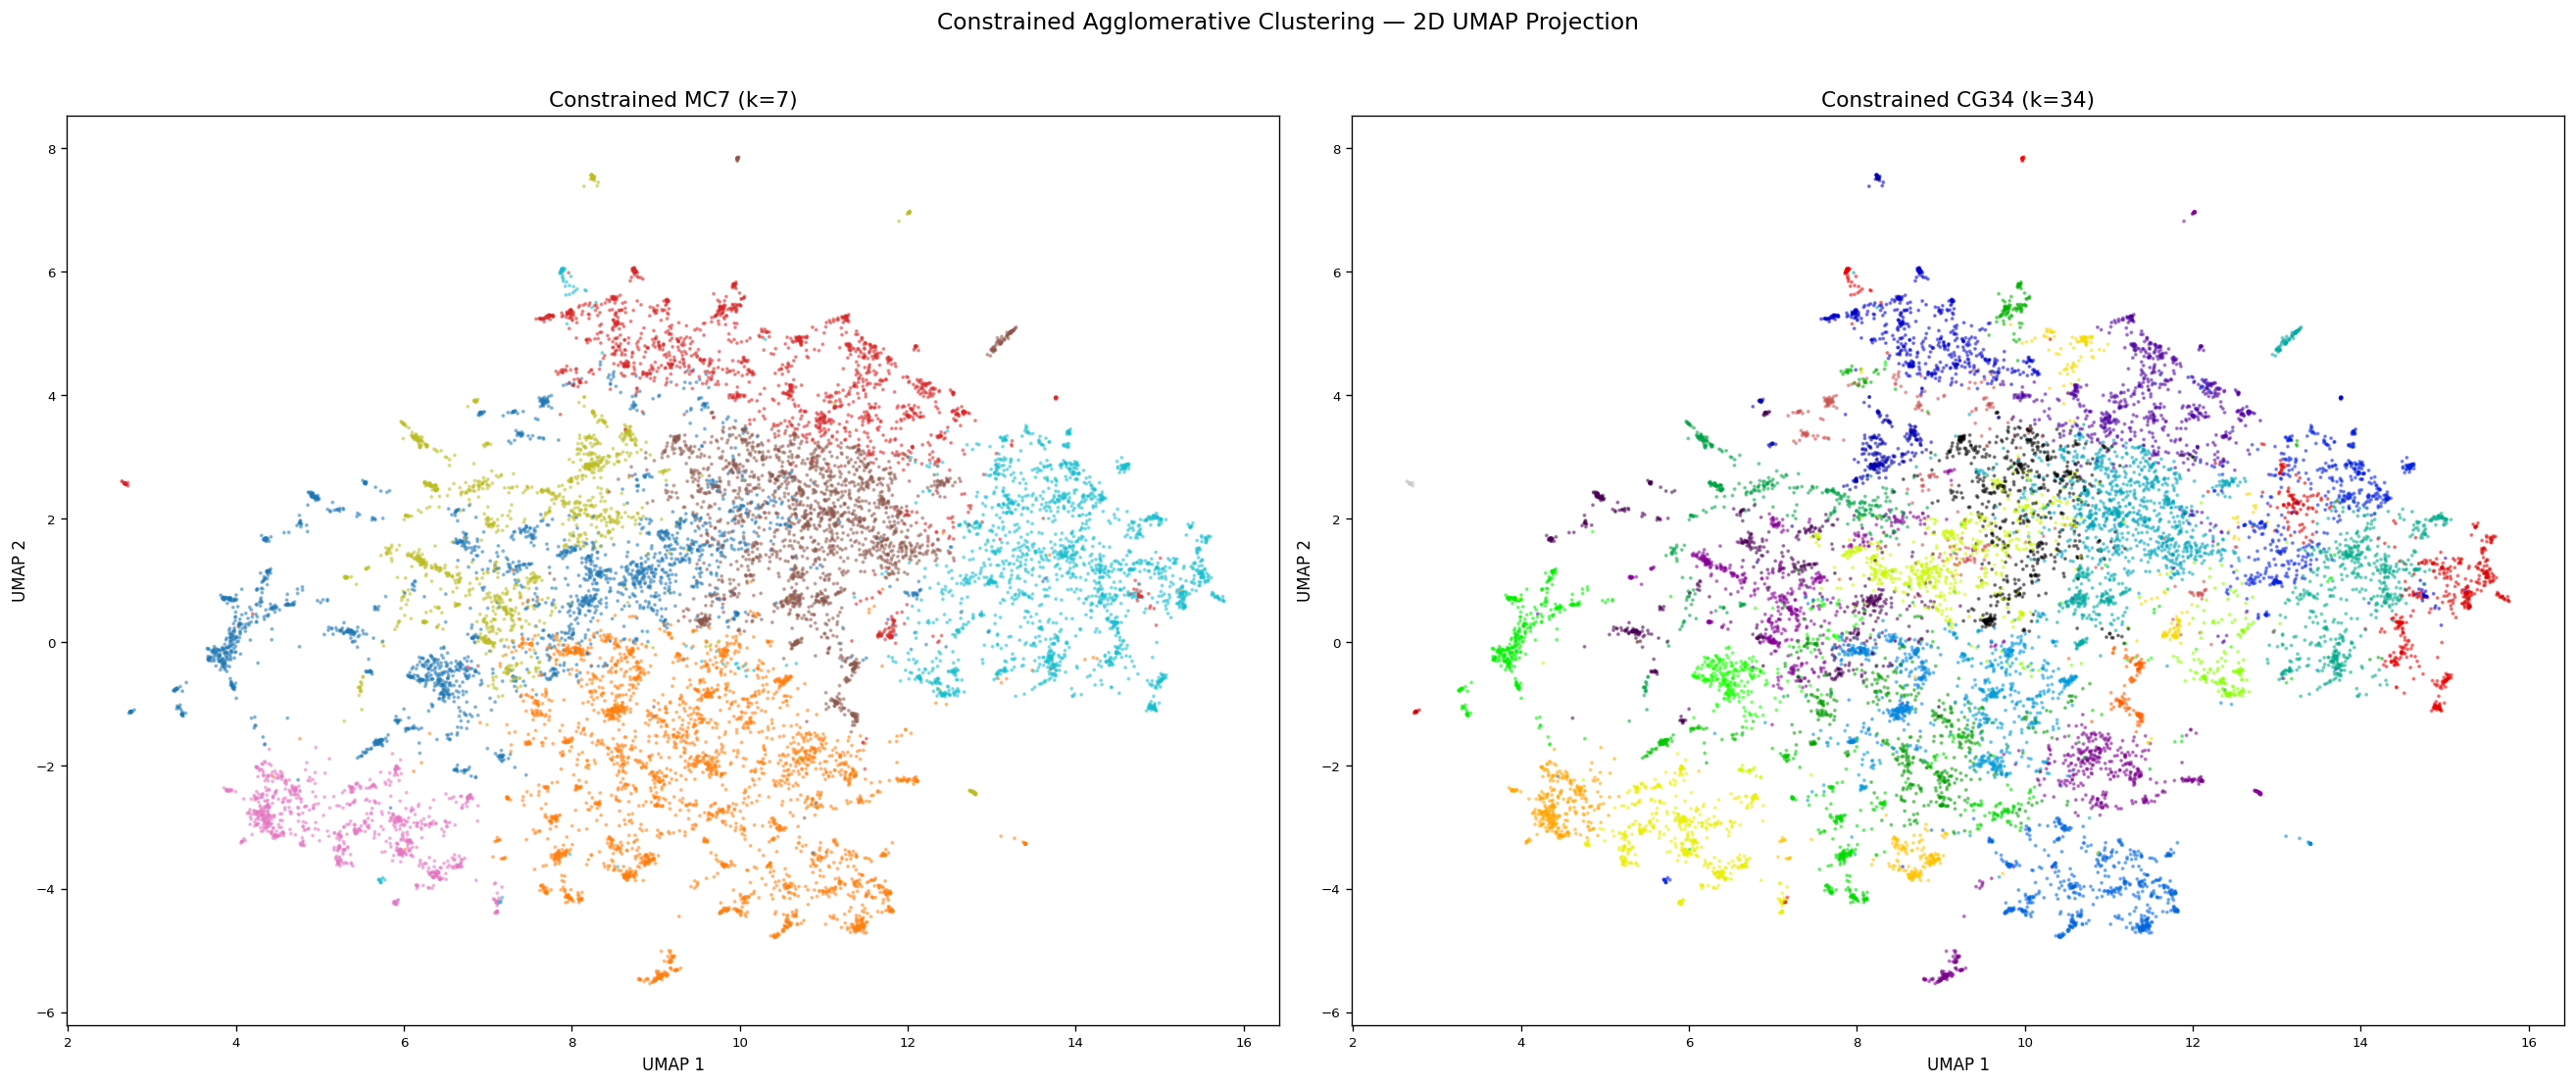

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/scatter_constrained.png


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(22, 9))

constrained_runs = {
    'Constrained MC7 (k=7)': labels_mc7,
    'Constrained CG34 (k=34)': labels_cg34,
}

for ax, (title, labels) in zip(axes, constrained_runs.items()):
    k = len(set(labels))
    cmap = plt.cm.get_cmap('tab10' if k <= 10 else 'nipy_spectral', k)

    ax.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=labels, cmap=cmap, s=2, alpha=0.4, rasterized=True,
    )
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('UMAP 1', fontsize=10)
    ax.set_ylabel('UMAP 2', fontsize=10)
    ax.tick_params(labelsize=8)

plt.suptitle('Constrained Agglomerative Clustering \u2014 2D UMAP Projection',
             fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'scatter_constrained.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "scatter_constrained.png"}')

### Per-Cluster Type Distribution

Using the same heatmap approach from Section 2, we examine the Ho type composition
of each constrained cluster. The key comparison: **do seed-constrained clusters
achieve higher type purity than unconstrained clusters at similar k?**

If constrained MC7 (k=7) shows purer clusters than unconstrained k=8, the expert
seed words are successfully imposing wordplay-type structure that the embedding
space alone does not naturally produce.

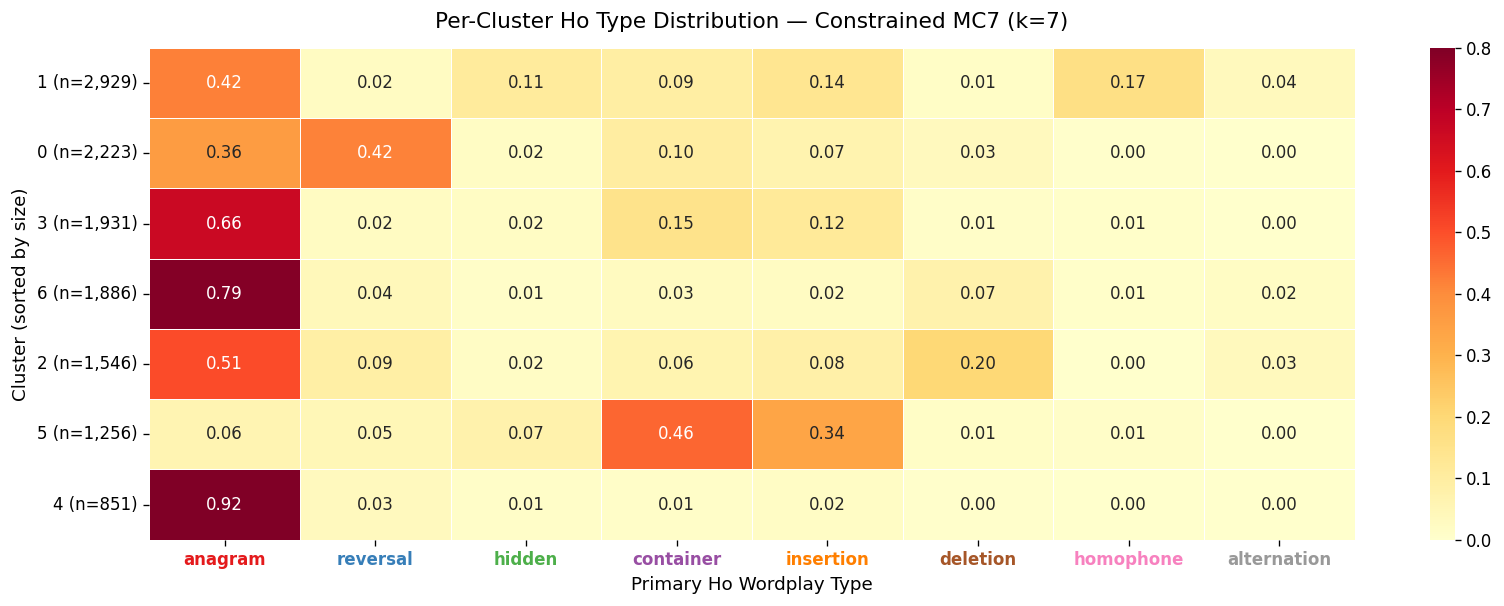

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/type_distribution_constrained_mc7_k7.png


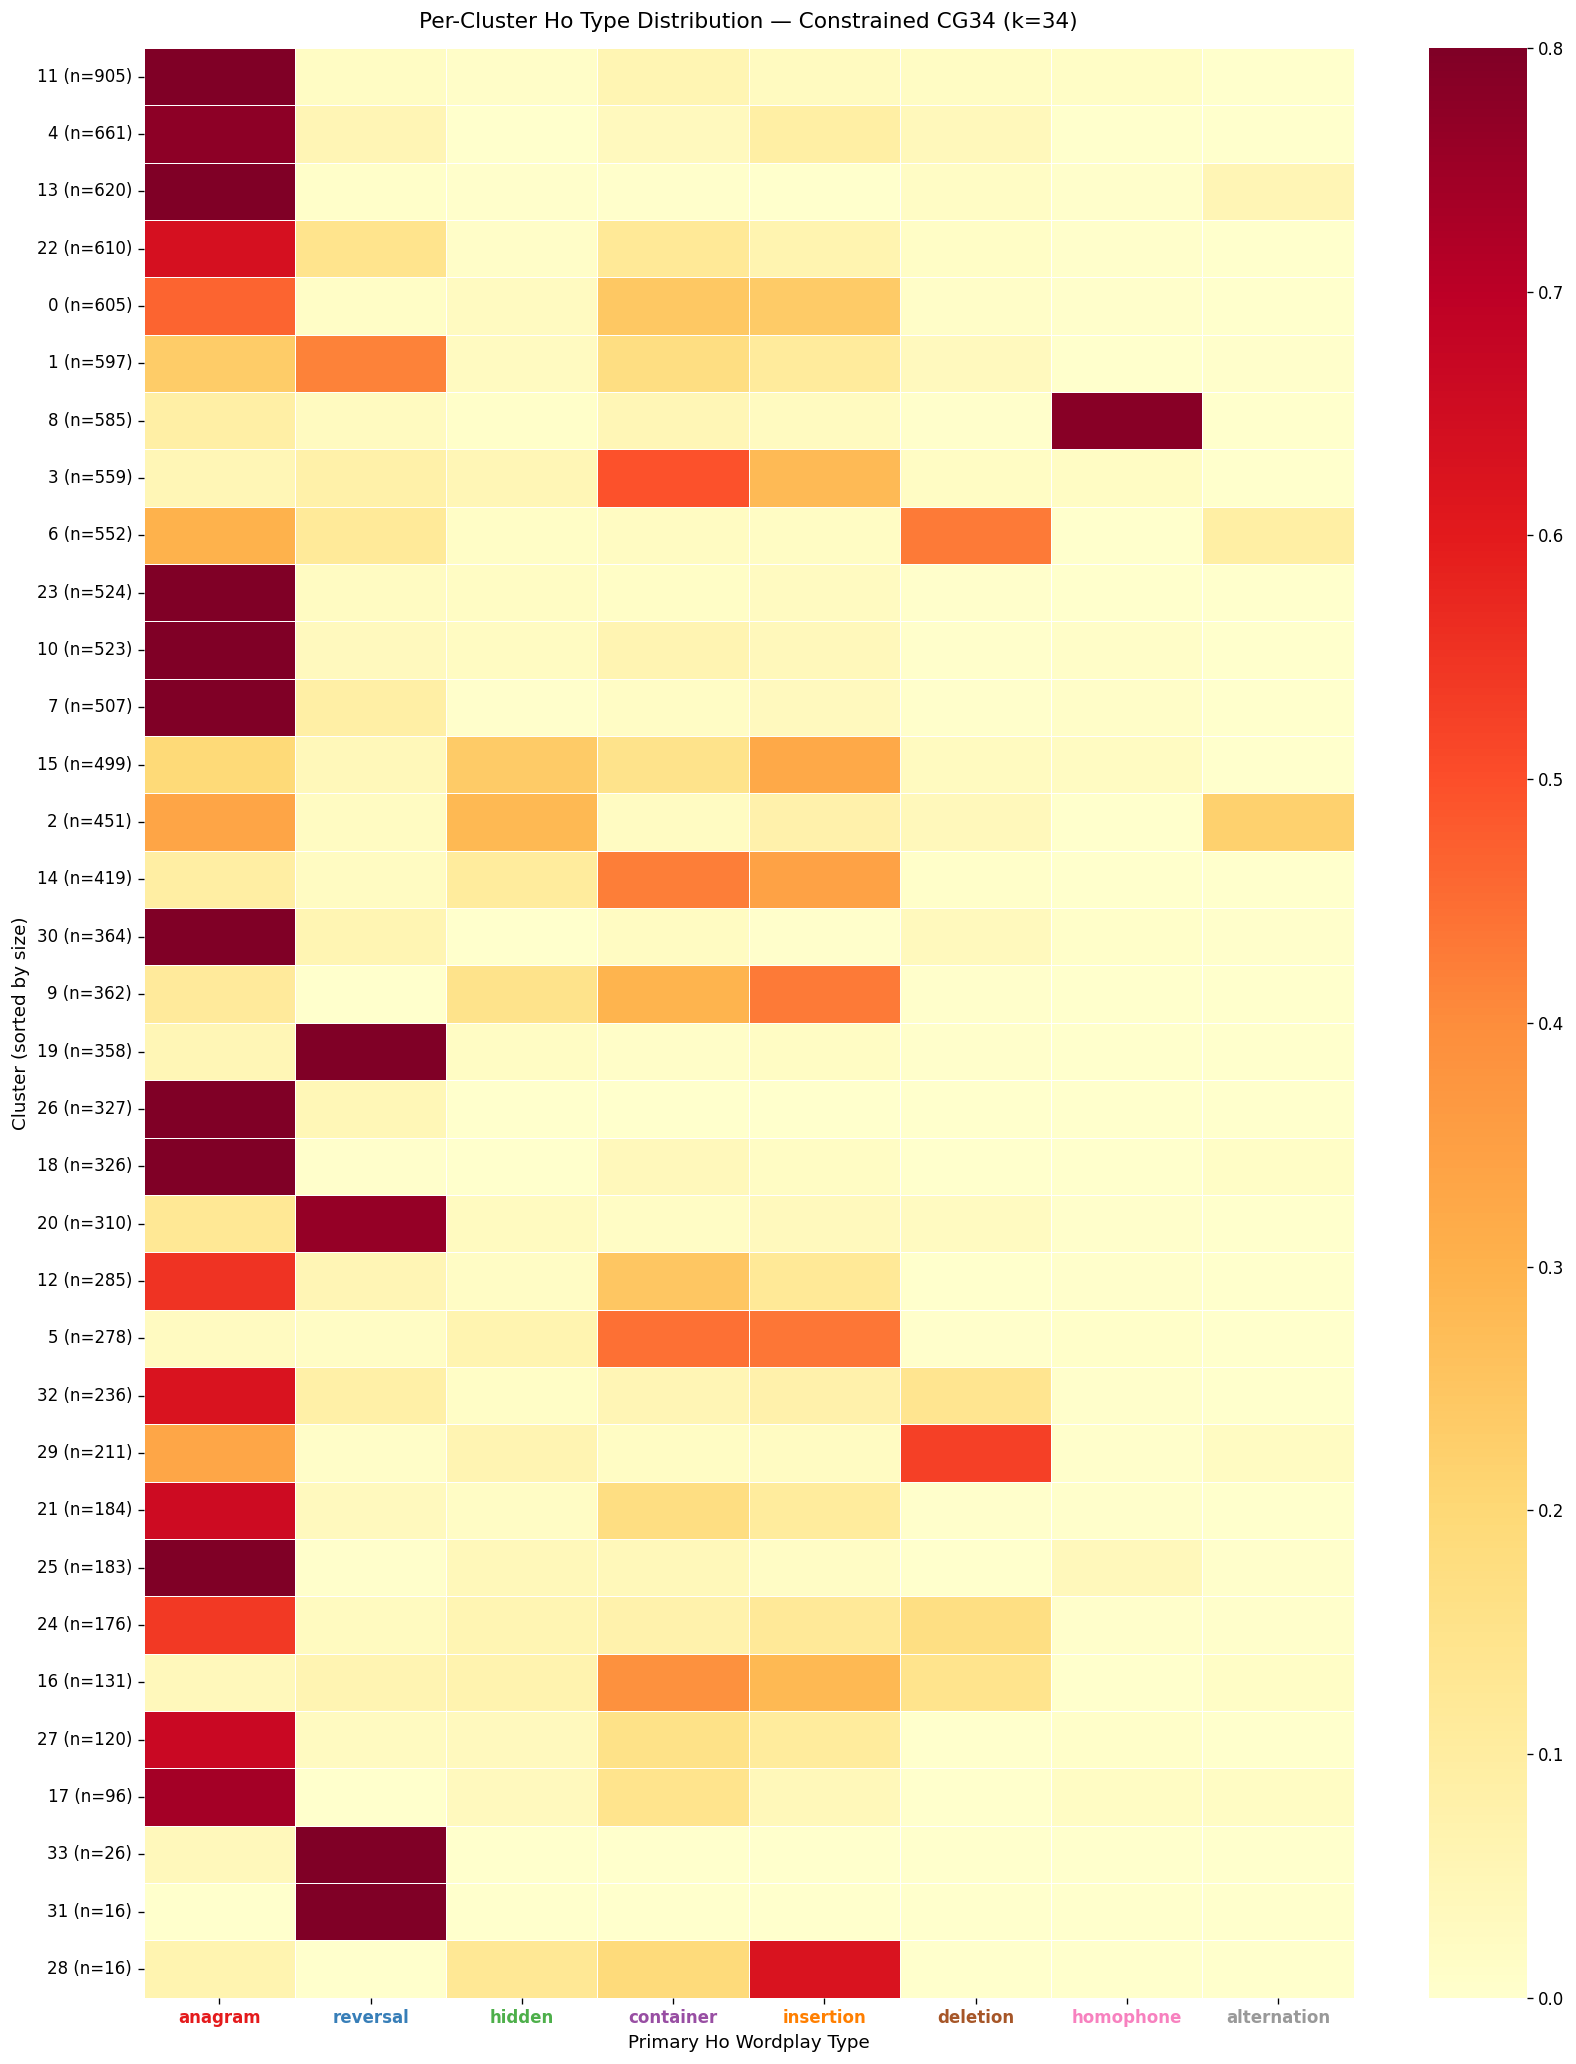

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures/type_distribution_constrained_cg34_k34.png


In [23]:
# --- Per-cluster type distribution heatmaps ---
constrained_type_dists = {}

for run_name, labels in constrained_runs.items():
    safe_name = (run_name.lower()
                 .replace(' ', '_').replace('(', '').replace(')', '')
                 .replace('=', ''))
    ct_norm = plot_type_distribution(
        cluster_labels=labels,
        primary_ho=primary_ho_array,
        ho_types=HO_TYPES,
        type_colors=TYPE_COLORS,
        title=f'Per-Cluster Ho Type Distribution \u2014 {run_name}',
        filename=f'type_distribution_{safe_name}.png',
        max_clusters=40,
        show_noise=False,
    )
    constrained_type_dists[run_name] = ct_norm

In [24]:
# --- Dominant type and purity per cluster ---
for run_name, ct_norm in constrained_type_dists.items():
    print(f'\n{"=" * 60}')
    print(f'{run_name}')
    print(f'{"=" * 60}')
    for idx in ct_norm.index:
        row = ct_norm.loc[idx]
        dominant = row.idxmax()
        purity = row.max()
        print(f'  Cluster {str(idx):>6s}: dominant={dominant:<20s} purity={purity:.2f}')
    avg_purity = ct_norm.max(axis=1).mean()
    print(f'\n  Average cluster purity: {avg_purity:.3f}')

# --- Summary: purity across ALL runs (unconstrained + constrained) ---
print(f'\n{"=" * 60}')
print('Average Cluster Purity \u2014 All Runs')
print(f'{"=" * 60}')

# Unconstrained (from Section 2)
for run_name, ct_norm in type_dist_results.items():
    numeric_rows = ct_norm.loc[ct_norm.index != 'noise']
    avg = numeric_rows.max(axis=1).mean()
    print(f'  {run_name:<40s}: {avg:.3f}')

# Constrained (this section)
for run_name, ct_norm in constrained_type_dists.items():
    avg = ct_norm.max(axis=1).mean()
    print(f'  {run_name:<40s}: {avg:.3f}')


Constrained MC7 (k=7)
  Cluster      1: dominant=anagram              purity=0.42
  Cluster      0: dominant=reversal             purity=0.42
  Cluster      3: dominant=anagram              purity=0.66
  Cluster      6: dominant=anagram              purity=0.79
  Cluster      2: dominant=anagram              purity=0.51
  Cluster      5: dominant=container            purity=0.46
  Cluster      4: dominant=anagram              purity=0.92

  Average cluster purity: 0.598

Constrained CG34 (k=34)
  Cluster     11: dominant=anagram              purity=0.84
  Cluster      4: dominant=anagram              purity=0.78
  Cluster     13: dominant=anagram              purity=0.91
  Cluster     22: dominant=anagram              purity=0.64
  Cluster      0: dominant=anagram              purity=0.46
  Cluster      1: dominant=reversal             purity=0.42
  Cluster      8: dominant=homophone            purity=0.78
  Cluster      3: dominant=container            purity=0.50
  Cluster      6: d

### Qualitative Inspection: Centroid-Nearest Indicators

For each constrained cluster, we compute the cluster centroid (mean of the 10D
embeddings of all indicators in the cluster) and find the 8 indicators closest
to that centroid. These "most representative" indicators reveal what each cluster
is about — whether it captured a coherent theme and whether that theme aligns
with a specific wordplay type.

**How to interpret:**
- If centroid-nearest indicators all serve the same wordplay type, the cluster
  successfully captured that type's vocabulary.
- If they span multiple types, the cluster is organized around a **conceptual
  metaphor** (e.g., spatial placement) that crosses type boundaries. This is
  expected for types like container/insertion/hidden that share placement concepts.
- Compare to the unconstrained k=8 and k=34 centroids from NB 04 to see if
  constraints shifted cluster centers toward more type-coherent positions.

In [25]:
from scipy.spatial.distance import cdist


def inspect_cluster_centroids(labels, embeddings, indicator_names, primary_ho,
                               n_nearest=8, max_clusters=None):
    """Print centroid-nearest indicators and type distribution per cluster.

    Parameters
    ----------
    labels : array of int
        Cluster assignment for each indicator.
    embeddings : ndarray, shape (n_samples, n_features)
        Embedding matrix (10D).
    indicator_names : array of str
        Indicator strings aligned with embeddings.
    primary_ho : array of str
        Primary Ho label per indicator.
    n_nearest : int
        Number of nearest indicators to show per cluster.
    max_clusters : int or None
        If set, only show this many clusters (largest first).
    """
    unique_labels = sorted(set(labels))

    if max_clusters is not None:
        # Sort by cluster size descending, take top N
        sizes = {cl: (labels == cl).sum() for cl in unique_labels}
        unique_labels = sorted(sizes, key=sizes.get, reverse=True)[:max_clusters]

    for cl in unique_labels:
        mask = labels == cl
        cluster_size = mask.sum()

        # Cluster centroid in 10D
        centroid = embeddings[mask].mean(axis=0).reshape(1, -1)

        # Distances from centroid to all cluster members
        dists = cdist(centroid, embeddings[mask], metric='euclidean')[0]
        nearest_local = np.argsort(dists)[:n_nearest]

        # Map local indices back to full-array indices
        cluster_indices = np.where(mask)[0]
        nearest_full = cluster_indices[nearest_local]

        # Type distribution for this cluster
        types_in_cluster = pd.Series(primary_ho[mask])
        type_dist = types_in_cluster.value_counts(normalize=True)
        dominant = type_dist.index[0]
        purity = type_dist.iloc[0]
        type_str = ', '.join(f'{t}: {p:.0%}' for t, p in type_dist.head(3).items())

        # Nearest indicators
        nearest_strs = [indicator_names[i] for i in nearest_full]

        print(f'Cluster {cl} (n={cluster_size:,}, '
              f'dominant={dominant}, purity={purity:.2f}):')
        print(f'  Types: {type_str}')
        print(f'  Nearest: {nearest_strs}')
        print()


print('=== Constrained MC7 (k=7): Centroid-Nearest Indicators ===\n')
inspect_cluster_centroids(
    labels_mc7, embeddings_10d, indicator_names, primary_ho_array,
)

print(f'\n{"=" * 60}\n')

print('=== Constrained CG34 (k=34): Centroid-Nearest Indicators ===\n')
inspect_cluster_centroids(
    labels_cg34, embeddings_10d, indicator_names, primary_ho_array,
    max_clusters=20,  # top 20 by size to keep output manageable
)

=== Constrained MC7 (k=7): Centroid-Nearest Indicators ===

Cluster 0 (n=2,223, dominant=reversal, purity=0.42):
  Types: reversal: 42%, anagram: 36%, container: 10%
  Nearest: ['on its head', 'on the hoof', 'starting from the end', 'sent round', 'kicking off', 'to go', 'parked in', 'going head over heels']

Cluster 1 (n=2,929, dominant=anagram, purity=0.42):
  Types: anagram: 42%, homophone: 17%, insertion: 14%
  Nearest: ['in special display', 'for it', 'given special display', 'that', 'its', 'anagrams', 'about that', 'about it']

Cluster 2 (n=1,546, dominant=anagram, purity=0.51):
  Types: anagram: 51%, deletion: 20%, reversal: 9%
  Nearest: ['spared', 'flushed', 'trash', 'discards', 'dumping', 'rubbishy', 'rubbish', 'trashy']

Cluster 3 (n=1,931, dominant=anagram, purity=0.66):
  Types: anagram: 66%, container: 15%, insertion: 12%
  Nearest: ['to mush', 'sow', 'juiced', 'pelting', 'melting', 'pickle', 'noodles', 'mashed']

Cluster 4 (n=851, dominant=anagram, purity=0.92):
  Types: 

### Save Section 3 Outputs

We save constrained cluster labels and metrics for use in Notebook 06 (evaluation
and report figures) and for comparison across all clustering methods.

In [26]:
# --- Save constrained cluster labels ---
for label_name, labels, filename in [
    ('Constrained MC7', labels_mc7, 'cluster_labels_constrained_mc7.csv'),
    ('Constrained CG34', labels_cg34, 'cluster_labels_constrained_cg34.csv'),
]:
    df_out = pd.DataFrame({
        'indicator': indicator_names,
        'cluster_label': labels,
    })
    out_path = DATA_DIR / filename
    df_out.to_csv(out_path, index=False)
    print(f'Saved: {out_path}')

# --- Save metrics comparison ---
df_comparison.to_csv(
    OUTPUT_DIR / 'constrained_vs_unconstrained_metrics.csv', index=False)
print(f'Saved: {OUTPUT_DIR / "constrained_vs_unconstrained_metrics.csv"}')

# --- Save constrained type distribution tables ---
for run_name, ct_norm in constrained_type_dists.items():
    safe_name = (run_name.lower()
                 .replace(' ', '_').replace('(', '').replace(')', '')
                 .replace('=', ''))
    out_path = OUTPUT_DIR / f'type_distribution_{safe_name}.csv'
    ct_norm.to_csv(out_path)
    print(f'Saved: {out_path}')

# --- List all Section 3 outputs ---
print(f'\nSection 3 figures in {FIGURES_DIR}:')
for pattern in ['scatter_constrained*', 'type_distribution_constrained*']:
    for f in sorted(FIGURES_DIR.glob(pattern)):
        print(f'  {f.name}')

Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/data/cluster_labels_constrained_mc7.csv
Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/data/cluster_labels_constrained_cg34.csv
Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/constrained_vs_unconstrained_metrics.csv
Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/type_distribution_constrained_mc7_k7.csv
Saved: /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/type_distribution_constrained_cg34_k34.csv

Section 3 figures in /Users/victoria/Desktop/MADS/ccc-project/indicator_clustering/outputs/figures:
  scatter_constrained.png
  type_distribution_constrained_cg34_k34.png
  type_distribution_constrained_mc7_k7.png


### Interpretation: Does Expert Knowledge Improve Clustering?

#### MC7 (k=7): Wordplay-Type Level

Compare constrained MC7 purity to the unconstrained k=8 baseline:

- **Which types benefited most from constraints?** Expect homophone and reversal
  to remain strong (they were already spatially concentrated in the overlay plots).
  The most interesting question is whether container+insertion, hidden, and deletion
  — the types that overlapped most in the unconstrained analysis — improved.
- **Did merging container+insertion help?** If the combined cluster is purer than
  the separate container and insertion clusters would be, the merge was justified.
  This confirms the DOMAIN_KNOWLEDGE.md prediction that these inverse operations
  share too much indicator vocabulary to separate.
- **Anagram dominance:** Anagram accounts for ~51% of indicators. In unconstrained
  k=8, multiple clusters were anagram-dominated simply by base rate. Did the MC7
  seeds help confine anagram to fewer, purer clusters?

#### CG34 (k=34): Conceptual-Metaphor Level

Compare constrained CG34 to unconstrained k=34:

- **Do conceptual-metaphor clusters align better with types?** If clusters like
  "movement", "disorder", "tamper" all map cleanly to anagram, while "containing",
  "surrounding", "holding" map to container/insertion, the conceptual hierarchy from
  DOMAIN_KNOWLEDGE.md is empirically supported.
- **Which concepts span multiple types?** These are the shared-metaphor groups
  (e.g., "containing" seeds appear under container, hidden, AND insertion). Their
  type distribution reveals whether the embedding space respects the type boundary
  or the conceptual-metaphor boundary.
- **Centroid inspection:** Do the nearest-to-centroid indicators confirm the
  conceptual-metaphor interpretation? If the "movement" cluster's nearest words
  are "dancing", "stirring", "mixing", the conceptual label is validated.

#### What These Results Mean for the Report

**If constrained > unconstrained:** Expert knowledge provides meaningful structure
that the embedding space alone does not produce. The report can frame this as
"semi-supervised clustering outperforms purely unsupervised methods."

**If constrained ≈ unconstrained:** Seeds are compatible with the natural structure
but redundant — the embedding model already captured the relevant organization.
This is still a positive finding: the BGE-M3 embeddings faithfully encode
wordplay-relevant semantics without needing expert guidance.

**If constrained < unconstrained:** The expert categories conflict with the embedding
geometry. This would suggest that the traditional wordplay taxonomy does not map
cleanly onto distributional semantics — a meaningful finding about the gap between
how CCC solvers categorize indicators and how language models represent them.

Any of these outcomes advances the project's central question about whether
wordplay type structure is recoverable from indicator semantics.

---
## Section 4: Subset Experiments

Sections 2 and 3 clustered all 12,622 indicators together. This section takes a
different approach: **filter to targeted subsets** and cluster only those indicators.
Each subset tests a specific hypothesis from DOMAIN_KNOWLEDGE.md about which wordplay
types should be easy vs. hard to distinguish.

Three experiments:
1. **4A — Easy Separation (Homophone vs. Reversal):** These types invoke fundamentally
   different conceptual metaphors (hearing/speaking vs. backward movement). If any
   pair should separate cleanly into 2 clusters, it is this one.
2. **4B — Hard Overlap (Hidden + Container + Insertion):** These types share the
   conceptual metaphor of spatial placement. We predict they will NOT separate cleanly.
3. **4C — Anagram Sub-clustering:** Anagram is the largest type (~51% of indicators)
   with the most diverse vocabulary. We look for sub-structure corresponding to
   conceptual metaphor categories (disorder, movement, tamper, etc.).

**Important simplification:** We reuse the full-data UMAP coordinates (10D for
clustering, 2D for visualization) rather than re-running UMAP on each subset. This
means each subset's points retain their positions from the full embedding space.
Re-running UMAP on subsets could reveal different local structure and is a possible
robustness check for future work, but is out of scope here.

**Evaluation metric — Adjusted Rand Index (ARI):** ARI measures agreement between
two categorical labelings of the same data, adjusted for chance. ARI = 1.0 means
perfect agreement; ARI = 0.0 means no better than random assignment; ARI can be
slightly negative if agreement is worse than random. We use ARI to compare cluster
assignments against Ho primary labels in experiments 4A and 4B.

In [ ]:
# Section 4 requires HDBSCAN (used in NB 04 but not yet imported in this notebook)
# and ARI for comparing cluster assignments to Ho labels
import hdbscan
from sklearn.metrics import adjusted_rand_score

print(f'hdbscan version: {hdbscan.__version__}')

### 4A: Easy Separation — Homophone vs. Reversal

**Hypothesis:** Homophone indicators (e.g., "sounds like", "I hear", "reportedly")
invoke hearing/speaking metaphors. Reversal indicators (e.g., "backwards", "returned",
"rising") invoke backward direction or reflection. These conceptual fields are
semantically distant, so a k=2 clustering should recover the type distinction.

**Why this pair?** The Section 2 overlay plots showed homophone and reversal occupying
distinct, concentrated regions of the UMAP space — exactly the conditions where
clustering should succeed. If we cannot separate even this "easy" pair, the harder
pairs will certainly fail too.

**Subset construction:** An indicator is included if it has *ever* been labeled
homophone or reversal in the Ho dataset. Multi-label indicators (e.g., one that
appears as both homophone and reversal across different clues) are included; their
primary Ho label determines the "true" label for ARI calculation.

In [ ]:
# --- Build homophone-vs-reversal subset ---
# An indicator is included if it has EVER been labeled homophone OR reversal
mask_easy = ho_type_masks['homophone'] | ho_type_masks['reversal']

# Subset embeddings and metadata (using full-data UMAP coordinates)
embeddings_10d_easy = embeddings_10d[mask_easy]
embeddings_2d_easy = embeddings_2d[mask_easy]
names_easy = indicator_names[mask_easy]
primary_ho_easy = primary_ho_array[mask_easy]

# Count by primary label
n_homophone = (primary_ho_easy == 'homophone').sum()
n_reversal = (primary_ho_easy == 'reversal').sum()
n_other_easy = len(primary_ho_easy) - n_homophone - n_reversal

print(f'Easy-separation subset: {mask_easy.sum():,} indicators')
print(f'  homophone (primary): {n_homophone:,}')
print(f'  reversal  (primary): {n_reversal:,}')
print(f'  other primary label: {n_other_easy:,} (multi-label indicators '
      f'whose most common Ho type is neither homophone nor reversal)')

In [ ]:
# --- Agglomerative k=2 ---
# Ward's linkage on the 10D UMAP embeddings, forced into 2 clusters
agglo_easy = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_agglo_easy = agglo_easy.fit_predict(embeddings_10d_easy)

sil_agglo_easy = silhouette_score(embeddings_10d_easy, labels_agglo_easy)
print(f'Agglomerative k=2: silhouette = {sil_agglo_easy:.4f}')

# Cluster sizes
for cl in sorted(set(labels_agglo_easy)):
    n = (labels_agglo_easy == cl).sum()
    print(f'  Cluster {cl}: {n:,} indicators')

# --- HDBSCAN ---
# min_cluster_size=10 matches NB 04; metric='euclidean' because input is 10D UMAP
hdb_easy = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
labels_hdb_easy = hdb_easy.fit_predict(embeddings_10d_easy)

n_clusters_hdb_easy = len(set(labels_hdb_easy)) - (1 if -1 in labels_hdb_easy else 0)
n_noise_hdb_easy = (labels_hdb_easy == -1).sum()
print(f'\nHDBSCAN: {n_clusters_hdb_easy} clusters, '
      f'{n_noise_hdb_easy} noise points ({n_noise_hdb_easy / len(labels_hdb_easy):.1%})')

# Silhouette for HDBSCAN (excluding noise points, which have label -1)
non_noise_easy = labels_hdb_easy != -1
if non_noise_easy.sum() > 1 and len(set(labels_hdb_easy[non_noise_easy])) > 1:
    sil_hdb_easy = silhouette_score(
        embeddings_10d_easy[non_noise_easy],
        labels_hdb_easy[non_noise_easy],
    )
    print(f'HDBSCAN silhouette (excl. noise): {sil_hdb_easy:.4f}')
else:
    sil_hdb_easy = np.nan
    print('HDBSCAN: not enough non-noise clusters for silhouette')

In [ ]:
# --- Side-by-side scatter: cluster assignment vs. Ho labels ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left panel: Agglomerative k=2 cluster colors
cmap_2 = plt.cm.get_cmap('tab10', 2)
axes[0].scatter(
    embeddings_2d_easy[:, 0], embeddings_2d_easy[:, 1],
    c=labels_agglo_easy, cmap=cmap_2, s=8, alpha=0.5, rasterized=True,
)
axes[0].set_title('Agglomerative k=2 \u2014 Cluster Assignment', fontsize=12)
axes[0].set_xlabel('UMAP 1', fontsize=10)
axes[0].set_ylabel('UMAP 2', fontsize=10)

# Right panel: Ho primary labels (using project color palette)
for label in ['homophone', 'reversal']:
    mask_label = primary_ho_easy == label
    axes[1].scatter(
        embeddings_2d_easy[mask_label, 0], embeddings_2d_easy[mask_label, 1],
        c=TYPE_COLORS[label], s=8, alpha=0.5, label=label, rasterized=True,
    )
# Multi-label indicators with a different primary type shown in gray
mask_other_easy = ~np.isin(primary_ho_easy, ['homophone', 'reversal'])
if mask_other_easy.any():
    axes[1].scatter(
        embeddings_2d_easy[mask_other_easy, 0],
        embeddings_2d_easy[mask_other_easy, 1],
        c='gray', s=8, alpha=0.3, label='other primary', rasterized=True,
    )
axes[1].set_title('Ho Primary Labels', fontsize=12)
axes[1].set_xlabel('UMAP 1', fontsize=10)
axes[1].set_ylabel('UMAP 2', fontsize=10)
axes[1].legend(markerscale=3, fontsize=9)

plt.suptitle('4A: Easy Separation \u2014 Homophone vs. Reversal',
             fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'subset_4a_easy_separation.png',
            dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "subset_4a_easy_separation.png"}')

In [ ]:
# --- ARI: how well do clusters recover the homophone/reversal distinction? ---

# Agglomerative k=2 vs. Ho primary labels
# ARI works with any label types (strings, ints) — sklearn handles encoding
ari_agglo_easy = adjusted_rand_score(primary_ho_easy, labels_agglo_easy)
print(f'ARI (Agglomerative k=2 vs. Ho labels): {ari_agglo_easy:.4f}')

# HDBSCAN vs. Ho primary labels (excluding noise points)
if non_noise_easy.sum() > 1 and len(set(labels_hdb_easy[non_noise_easy])) > 1:
    ari_hdb_easy = adjusted_rand_score(
        primary_ho_easy[non_noise_easy],
        labels_hdb_easy[non_noise_easy],
    )
    print(f'ARI (HDBSCAN vs. Ho labels, excl. noise): {ari_hdb_easy:.4f}')
else:
    ari_hdb_easy = np.nan
    print('HDBSCAN: not enough non-noise clusters for ARI')

print()
print('Interpretation guide:')
print('  ARI = 1.0: clusters perfectly recover the homophone/reversal split')
print('  ARI > 0.5: strong agreement between clusters and Ho labels')
print('  ARI near 0: clustering is unrelated to the type distinction')
print('  ARI < 0:   agreement is worse than random (rare)')

#### 4A Interpretation

**Key questions to answer after running:**

- Did agglomerative k=2 cleanly separate homophone from reversal? A high ARI (>0.5)
  confirms these types are distinguishable in the embedding space.
- Did HDBSCAN find exactly 2 clusters, or did it discover finer sub-structure
  (e.g., separate clusters for "rising/lifted/up" vs. "backwards/returned")?
- How much noise did HDBSCAN assign? If substantial, check whether one type lost
  more points to noise than the other.
- Compare the left and right scatter panels: do the two agglomerative clusters
  visually align with the two Ho label colors?

This experiment establishes the **best-case baseline** for type separation. The ARI
achieved here is the upper bound we can expect for harder pairs in 4B.

### 4B: Hard Overlap — Hidden + Container + Insertion

**Hypothesis:** Hidden, container, and insertion indicators share the conceptual
metaphor of **spatial placement** — words like "in", "inside", "within",
"containing", "around", and "holding" serve all three types interchangeably.
DOMAIN_KNOWLEDGE.md identifies this as the hardest separation problem: container
and insertion are inverse operations (C1 inside C2 vs. C2 around C1), and hidden
shares "containment" vocabulary with both.

**Prediction:** ARI will be near 0 — clustering at k=3 will NOT recover the
three-way type distinction. Clusters may instead organize by conceptual sub-metaphor
(e.g., "surrounding" words vs. "consuming" words vs. "segment/piece" words) rather
than by wordplay type.

**Why this matters:** If these three types are truly inseparable in the embedding
space, the traditional 8-type taxonomy cannot be fully recovered by any clustering
method operating on indicator semantics alone. This is a meaningful finding about
the limits of distributional approaches to CCC indicator classification.

In [ ]:
# --- Build hidden/container/insertion subset ---
mask_hard = (ho_type_masks['hidden']
             | ho_type_masks['container']
             | ho_type_masks['insertion'])

embeddings_10d_hard = embeddings_10d[mask_hard]
embeddings_2d_hard = embeddings_2d[mask_hard]
names_hard = indicator_names[mask_hard]
primary_ho_hard = primary_ho_array[mask_hard]

# Count by primary label
print(f'Hard-overlap subset: {mask_hard.sum():,} indicators')
for wtype in ['hidden', 'container', 'insertion']:
    n = (primary_ho_hard == wtype).sum()
    print(f'  {wtype:>12s}: {n:>5,}')
n_other_hard = len(primary_ho_hard) - sum(
    (primary_ho_hard == t).sum() for t in ['hidden', 'container', 'insertion']
)
if n_other_hard > 0:
    print(f'  {"other":>12s}: {n_other_hard:>5,} (multi-label, primary is a different type)')

In [ ]:
# --- Agglomerative k=3 ---
agglo_hard = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agglo_hard = agglo_hard.fit_predict(embeddings_10d_hard)

sil_agglo_hard = silhouette_score(embeddings_10d_hard, labels_agglo_hard)
print(f'Agglomerative k=3: silhouette = {sil_agglo_hard:.4f}')

for cl in sorted(set(labels_agglo_hard)):
    n = (labels_agglo_hard == cl).sum()
    print(f'  Cluster {cl}: {n:,} indicators')

# --- HDBSCAN ---
hdb_hard = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
labels_hdb_hard = hdb_hard.fit_predict(embeddings_10d_hard)

n_clusters_hdb_hard = len(set(labels_hdb_hard)) - (1 if -1 in labels_hdb_hard else 0)
n_noise_hdb_hard = (labels_hdb_hard == -1).sum()
print(f'\nHDBSCAN: {n_clusters_hdb_hard} clusters, '
      f'{n_noise_hdb_hard} noise points ({n_noise_hdb_hard / len(labels_hdb_hard):.1%})')

non_noise_hard = labels_hdb_hard != -1
if non_noise_hard.sum() > 1 and len(set(labels_hdb_hard[non_noise_hard])) > 1:
    sil_hdb_hard = silhouette_score(
        embeddings_10d_hard[non_noise_hard],
        labels_hdb_hard[non_noise_hard],
    )
    print(f'HDBSCAN silhouette (excl. noise): {sil_hdb_hard:.4f}')
else:
    sil_hdb_hard = np.nan
    print('HDBSCAN: not enough non-noise clusters for silhouette')

In [ ]:
# --- Side-by-side scatter: cluster assignment vs. Ho labels ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left panel: Agglomerative k=3 cluster colors
cmap_3 = plt.cm.get_cmap('tab10', 3)
axes[0].scatter(
    embeddings_2d_hard[:, 0], embeddings_2d_hard[:, 1],
    c=labels_agglo_hard, cmap=cmap_3, s=8, alpha=0.5, rasterized=True,
)
axes[0].set_title('Agglomerative k=3 \u2014 Cluster Assignment', fontsize=12)
axes[0].set_xlabel('UMAP 1', fontsize=10)
axes[0].set_ylabel('UMAP 2', fontsize=10)

# Right panel: Ho primary labels
for label in ['hidden', 'container', 'insertion']:
    mask_label = primary_ho_hard == label
    axes[1].scatter(
        embeddings_2d_hard[mask_label, 0], embeddings_2d_hard[mask_label, 1],
        c=TYPE_COLORS[label], s=8, alpha=0.5, label=label, rasterized=True,
    )
# Multi-label indicators with a different primary type
mask_other_hard = ~np.isin(primary_ho_hard, ['hidden', 'container', 'insertion'])
if mask_other_hard.any():
    axes[1].scatter(
        embeddings_2d_hard[mask_other_hard, 0],
        embeddings_2d_hard[mask_other_hard, 1],
        c='gray', s=8, alpha=0.3, label='other primary', rasterized=True,
    )
axes[1].set_title('Ho Primary Labels', fontsize=12)
axes[1].set_xlabel('UMAP 1', fontsize=10)
axes[1].set_ylabel('UMAP 2', fontsize=10)
axes[1].legend(markerscale=3, fontsize=9)

plt.suptitle('4B: Hard Overlap \u2014 Hidden + Container + Insertion',
             fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'subset_4b_hard_overlap.png',
            dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "subset_4b_hard_overlap.png"}')

In [ ]:
# --- ARI: do clusters recover the hidden/container/insertion distinction? ---

# For a clean comparison, filter to indicators whose primary label is one of
# the 3 target types (exclude multi-label indicators with a different primary)
target_types_hard = ['hidden', 'container', 'insertion']
target_mask_hard = np.isin(primary_ho_hard, target_types_hard)

ari_agglo_hard = adjusted_rand_score(
    primary_ho_hard[target_mask_hard],
    labels_agglo_hard[target_mask_hard],
)
print(f'ARI (Agglomerative k=3 vs. Ho labels, target types only): '
      f'{ari_agglo_hard:.4f}')

# HDBSCAN ARI (exclude both noise and non-target primary labels)
hdb_target_hard = target_mask_hard & non_noise_hard
if hdb_target_hard.sum() > 1 and len(set(labels_hdb_hard[hdb_target_hard])) > 1:
    ari_hdb_hard = adjusted_rand_score(
        primary_ho_hard[hdb_target_hard],
        labels_hdb_hard[hdb_target_hard],
    )
    print(f'ARI (HDBSCAN vs. Ho labels, excl. noise, target types): '
          f'{ari_hdb_hard:.4f}')
else:
    ari_hdb_hard = np.nan
    print('HDBSCAN: insufficient non-noise target-type points for ARI')

# --- Direct comparison with 4A ---
print(f'\n--- Comparison ---')
print(f'  4A Easy (homophone vs reversal) ARI: {ari_agglo_easy:.4f}')
print(f'  4B Hard (hidden/container/insertion) ARI: {ari_agglo_hard:.4f}')
print(f'  Ratio: 4A is {ari_agglo_easy / max(ari_agglo_hard, 0.001):.1f}x '
      f'the 4B ARI')

#### 4B Interpretation

**Key questions to answer after running:**

- Was ARI near 0? This would confirm the placement-metaphor entanglement: the
  embedding space does not distinguish hidden, container, and insertion because
  their indicator vocabularies overlap too heavily.
- Did HDBSCAN find fine-grained clusters within this subset? If so, do they
  correspond to conceptual sub-metaphors (e.g., "surrounding" vs. "consuming"
  vs. "segment/piece of") rather than to the three Ho types?
- How does the 4B ARI compare to the 4A ARI? A large gap quantifies how much
  harder the placement-type distinction is than the homophone/reversal distinction.
- Look at the right scatter panel: are the three Ho label colors thoroughly
  intermixed, or is there any partial spatial separation?

**Implications for the full problem:** If three types are inseparable, then the
full 8-type clustering problem has at most 6 distinguishable groups (merging
hidden+container+insertion). This aligns with the MC7 constrained clustering
from Section 3, which merged container and insertion into a single group.

### 4C: Anagram Sub-clustering

**Research question:** Anagram is the largest wordplay type, accounting for ~51%
of all verified indicators (6,610 unique). Its indicator vocabulary spans many
conceptual metaphors: disorder ("jumbled", "confused"), movement ("stirring",
"dancing"), tampering ("cooked", "touched"), repair ("designed", "engineered"),
and incorrectness ("broken", "wrong", "ugly").

Can clustering reveal these conceptual sub-groups within anagram?

The `conceptual_groups` tab in `wordplay_seeds.xlsx` identifies 5 anagram-related
concepts:

| Concept | Example seeds |
|---------|--------------|
| disorder | bad, disobey, jumbled, naughty |
| incorrect | broken, mixed up, strange, ugly, wrong |
| tamper | cooked, touched |
| movement | dance, churning, movement, throw |
| repair | designed, engineered |

**Evaluation approach:** Since all indicators in this subset are anagram, ARI
against Ho labels is not meaningful (all labels are the same). Instead, we evaluate
**qualitatively** using `inspect_cluster_centroids()` to check whether sub-clusters
align with the conceptual metaphor categories above.

**Methods:** HDBSCAN to discover density-based sub-structure, then agglomerative
at k=4, 6, 8, 12 to explore different granularities.

In [ ]:
# --- Build anagram-only subset ---
mask_anagram = ho_type_masks['anagram']

embeddings_10d_ana = embeddings_10d[mask_anagram]
embeddings_2d_ana = embeddings_2d[mask_anagram]
names_ana = indicator_names[mask_anagram]
primary_ho_ana = primary_ho_array[mask_anagram]

print(f'Anagram subset: {mask_anagram.sum():,} indicators')
print(f'  Primary label = anagram: {(primary_ho_ana == "anagram").sum():,}')
print(f'  Primary label \u2260 anagram: {(primary_ho_ana != "anagram").sum():,} '
      f'(multi-label indicators where anagram is not the most frequent Ho label)')

In [ ]:
# --- HDBSCAN: discover density-based sub-structure within anagram ---
# Using default cluster_selection_epsilon (equivalent to eps=0 in the NB 04 sweep)
# min_cluster_size=10 is consistent with NB 04
hdb_ana = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
labels_hdb_ana = hdb_ana.fit_predict(embeddings_10d_ana)

n_clusters_hdb_ana = len(set(labels_hdb_ana)) - (1 if -1 in labels_hdb_ana else 0)
n_noise_hdb_ana = (labels_hdb_ana == -1).sum()

print(f'HDBSCAN on anagram subset:')
print(f'  Clusters found: {n_clusters_hdb_ana}')
print(f'  Noise points:   {n_noise_hdb_ana} ({n_noise_hdb_ana / len(labels_hdb_ana):.1%})')

# Size distribution of clusters
if n_clusters_hdb_ana > 0:
    sizes_hdb_ana = pd.Series(
        labels_hdb_ana[labels_hdb_ana != -1]
    ).value_counts()
    print(f'  Cluster sizes: min={sizes_hdb_ana.min()}, '
          f'max={sizes_hdb_ana.max()}, median={sizes_hdb_ana.median():.0f}')
    print(f'  Top 5 cluster sizes: {sizes_hdb_ana.head(5).tolist()}')

In [ ]:
# --- Agglomerative at multiple k values ---
# k=4:  fewer than the 5 conceptual categories — tests coarser grouping
# k=6:  near the number of conceptual categories
# k=8:  slightly finer — room for some categories to split
# k=12: finer still — tests whether sub-clusters fragment further
k_values_ana = [4, 6, 8, 12]
labels_agglo_ana = {}
metrics_agglo_ana = {}

for k in k_values_ana:
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_k = agglo.fit_predict(embeddings_10d_ana)
    labels_agglo_ana[k] = labels_k

    sil = silhouette_score(embeddings_10d_ana, labels_k)
    db = davies_bouldin_score(embeddings_10d_ana, labels_k)
    metrics_agglo_ana[k] = {'Silhouette': sil, 'Davies-Bouldin': db}

    sizes = pd.Series(labels_k).value_counts()
    print(f'k={k:>2d}: silhouette={sil:.4f}, DB={db:.4f}, '
          f'sizes: min={sizes.min()}, max={sizes.max()}, '
          f'median={sizes.median():.0f}')

In [ ]:
# --- Scatter plots: HDBSCAN + agglomerative at k=4, 8, 12 ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes_flat = axes.flatten()

# Panel 0: HDBSCAN
ax = axes_flat[0]
if n_clusters_hdb_ana > 0:
    # Noise points in light gray
    noise_mask_ana = labels_hdb_ana == -1
    ax.scatter(
        embeddings_2d_ana[noise_mask_ana, 0],
        embeddings_2d_ana[noise_mask_ana, 1],
        c='lightgray', s=3, alpha=0.2, rasterized=True, label='noise',
    )
    # Cluster points
    non_noise_ana = ~noise_mask_ana
    cmap_hdb = plt.cm.get_cmap('nipy_spectral', n_clusters_hdb_ana)
    ax.scatter(
        embeddings_2d_ana[non_noise_ana, 0],
        embeddings_2d_ana[non_noise_ana, 1],
        c=labels_hdb_ana[non_noise_ana], cmap=cmap_hdb,
        s=3, alpha=0.4, rasterized=True,
    )
else:
    ax.scatter(
        embeddings_2d_ana[:, 0], embeddings_2d_ana[:, 1],
        c='lightgray', s=3, alpha=0.3, rasterized=True,
    )
ax.set_title(f'HDBSCAN ({n_clusters_hdb_ana} clusters, '
             f'{n_noise_hdb_ana} noise)', fontsize=11)
ax.set_xlabel('UMAP 1', fontsize=9)
ax.set_ylabel('UMAP 2', fontsize=9)

# Panels 1-3: Agglomerative at k=4, 8, 12
for panel_idx, k in enumerate([4, 8, 12]):
    ax = axes_flat[panel_idx + 1]
    labels_k = labels_agglo_ana[k]
    cmap_k = plt.cm.get_cmap('tab10' if k <= 10 else 'nipy_spectral', k)
    ax.scatter(
        embeddings_2d_ana[:, 0], embeddings_2d_ana[:, 1],
        c=labels_k, cmap=cmap_k, s=3, alpha=0.4, rasterized=True,
    )
    sil_k = metrics_agglo_ana[k]['Silhouette']
    ax.set_title(f'Agglomerative k={k} (sil={sil_k:.3f})', fontsize=11)
    ax.set_xlabel('UMAP 1', fontsize=9)
    ax.set_ylabel('UMAP 2', fontsize=9)

plt.suptitle('4C: Anagram Sub-clustering \u2014 2D UMAP Projection',
             fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'subset_4c_anagram_subclusters.png',
            dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved: {FIGURES_DIR / "subset_4c_anagram_subclusters.png"}')

In [ ]:
# --- Qualitative inspection: what are the anagram sub-clusters about? ---
# We use inspect_cluster_centroids() to see the most representative indicators
# in each sub-cluster and judge whether they align with conceptual metaphor
# categories (disorder, incorrect, tamper, movement, repair).

print('=== HDBSCAN Anagram Sub-clusters: Centroid-Nearest Indicators ===\n')
if n_clusters_hdb_ana > 0:
    inspect_cluster_centroids(
        labels_hdb_ana, embeddings_10d_ana, names_ana, primary_ho_ana,
        n_nearest=8, max_clusters=15,
    )
else:
    print('No HDBSCAN clusters to inspect.')

print(f'\n{"=" * 60}\n')

print('=== Agglomerative k=8 Anagram Sub-clusters: Centroid-Nearest ===\n')
inspect_cluster_centroids(
    labels_agglo_ana[8], embeddings_10d_ana, names_ana, primary_ho_ana,
    n_nearest=8,
)

#### 4C Interpretation

**Key questions to answer after running:**

- **How many HDBSCAN sub-clusters were found?** If many (>50), they are likely
  morphological variant groups (e.g., "scrambled / scrambles / scrambling") rather
  than conceptual-metaphor clusters. If fewer (5–15), they may correspond to
  broader semantic themes.
- **Do agglomerative k=8 sub-clusters align with the 5 conceptual metaphors?**
  Look at the centroid-nearest indicators:
  - A "disorder" cluster should contain words like "confused", "jumbled", "messy"
  - A "movement" cluster should contain "stirring", "dancing", "tossing"
  - A "tamper" cluster should contain "cooked", "doctored", "altered"
  - An "incorrect" cluster should contain "wrong", "broken", "bad"
  - A "repair" cluster should contain "designed", "engineered", "rebuilt"
- **Which categories are distinct vs. merged?** Disorder and incorrect may overlap
  heavily (both describe something being "wrong"). Movement and tamper may overlap
  (both describe physical manipulation).
- **Does the existence of sub-structure matter?** If anagram indicators form
  interpretable sub-clusters, this supports the conceptual-metaphor hierarchy from
  DOMAIN_KNOWLEDGE.md as a genuine organizing principle — wordplay types are not
  monolithic categories but contain internal structure at the metaphor level.

In [ ]:
# =====================================================================
# Save Section 4 Outputs
# =====================================================================

# --- Subset cluster labels ---
subset_saves = [
    ('4A easy: Agglo k=2', labels_agglo_easy, names_easy,
     'cluster_labels_subset_easy_agglo_k2.csv'),
    ('4A easy: HDBSCAN', labels_hdb_easy, names_easy,
     'cluster_labels_subset_easy_hdbscan.csv'),
    ('4B hard: Agglo k=3', labels_agglo_hard, names_hard,
     'cluster_labels_subset_hard_agglo_k3.csv'),
    ('4B hard: HDBSCAN', labels_hdb_hard, names_hard,
     'cluster_labels_subset_hard_hdbscan.csv'),
    ('4C ana: HDBSCAN', labels_hdb_ana, names_ana,
     'cluster_labels_subset_anagram_hdbscan.csv'),
]

# Add each agglomerative k for the anagram experiment
for k in k_values_ana:
    subset_saves.append((
        f'4C ana: Agglo k={k}', labels_agglo_ana[k], names_ana,
        f'cluster_labels_subset_anagram_agglo_k{k}.csv',
    ))

for label_name, labels, names, filename in subset_saves:
    df_out = pd.DataFrame({
        'indicator': names,
        'cluster_label': labels,
    })
    out_path = DATA_DIR / filename
    df_out.to_csv(out_path, index=False)
    print(f'Saved: {out_path}')

# --- Section 4 metrics summary ---
metrics_rows = [
    {
        'Experiment': '4A Easy (Homophone vs Reversal)',
        'Method': 'Agglomerative k=2',
        'k': 2,
        'Silhouette': sil_agglo_easy,
        'ARI_vs_Ho': ari_agglo_easy,
        'Noise_pct': 0.0,
    },
    {
        'Experiment': '4A Easy (Homophone vs Reversal)',
        'Method': 'HDBSCAN',
        'k': n_clusters_hdb_easy,
        'Silhouette': sil_hdb_easy if not np.isnan(sil_hdb_easy) else np.nan,
        'ARI_vs_Ho': ari_hdb_easy if not np.isnan(ari_hdb_easy) else np.nan,
        'Noise_pct': (n_noise_hdb_easy / len(labels_hdb_easy)
                      if len(labels_hdb_easy) > 0 else np.nan),
    },
    {
        'Experiment': '4B Hard (Hidden/Container/Insertion)',
        'Method': 'Agglomerative k=3',
        'k': 3,
        'Silhouette': sil_agglo_hard,
        'ARI_vs_Ho': ari_agglo_hard,
        'Noise_pct': 0.0,
    },
    {
        'Experiment': '4B Hard (Hidden/Container/Insertion)',
        'Method': 'HDBSCAN',
        'k': n_clusters_hdb_hard,
        'Silhouette': sil_hdb_hard if not np.isnan(sil_hdb_hard) else np.nan,
        'ARI_vs_Ho': ari_hdb_hard if not np.isnan(ari_hdb_hard) else np.nan,
        'Noise_pct': (n_noise_hdb_hard / len(labels_hdb_hard)
                      if len(labels_hdb_hard) > 0 else np.nan),
    },
]

# Anagram agglomerative runs (no ARI — all indicators are the same Ho type)
for k in k_values_ana:
    metrics_rows.append({
        'Experiment': '4C Anagram Sub-clustering',
        'Method': f'Agglomerative k={k}',
        'k': k,
        'Silhouette': metrics_agglo_ana[k]['Silhouette'],
        'ARI_vs_Ho': np.nan,
        'Noise_pct': 0.0,
    })

df_section4_metrics = pd.DataFrame(metrics_rows)
df_section4_metrics.to_csv(
    OUTPUT_DIR / 'subset_experiment_metrics.csv', index=False)
print(f'\nSaved: {OUTPUT_DIR / "subset_experiment_metrics.csv"}')

# Display formatted
df_disp = df_section4_metrics.copy()
for col in ['Silhouette', 'ARI_vs_Ho', 'Noise_pct']:
    df_disp[col] = df_disp[col].map(
        lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A'
    )
print('\n=== Section 4: Subset Experiment Metrics ===\n')
print(df_disp.to_string(index=False))

# =====================================================================
# Complete NB 05 output listing (all sections)
# =====================================================================
print(f'\n{"=" * 60}')
print('COMPLETE NB 05 OUTPUT FILES')
print(f'{"=" * 60}')

print(f'\n--- Cluster label files ({DATA_DIR}) ---')
for pattern in ['cluster_labels_constrained_*',
                'cluster_labels_subset_*']:
    for f in sorted(DATA_DIR.glob(pattern)):
        print(f'  {f.name}')

print(f'\n--- Metrics and tables ({OUTPUT_DIR}) ---')
for pattern in ['constrained_*', 'type_distribution_*',
                'subset_experiment*']:
    for f in sorted(OUTPUT_DIR.glob(pattern)):
        print(f'  {f.name}')

print(f'\n--- Figures ({FIGURES_DIR}) ---')
for pattern in ['overlay_*', 'type_distribution_*',
                'scatter_constrained*', 'subset_*']:
    for f in sorted(FIGURES_DIR.glob(pattern)):
        print(f'  {f.name}')

---
## Notebook Summary: What Did We Learn?

This notebook introduced domain knowledge (wordplay labels, seed words, and targeted
subsets) into the clustering analysis for the first time. Four questions were
addressed:

### 1. Do unconstrained clusters correspond to wordplay types? (Section 2)

The per-type overlay plots and heatmaps reveal how NB 04's unconstrained clusters
relate to the 8 Ho wordplay types. Key patterns to note:
- Which types formed tight, concentrated regions in the embedding space?
- Which types were dispersed or interleaved with other types?
- Did finer granularity (k=34) produce purer clusters than coarser (k=8)?

### 2. Does constrained clustering improve on unconstrained? (Section 3)

Constrained agglomerative clustering with seed-word connectivity was compared to
unconstrained baselines at matched k. The metrics comparison and purity analysis
show whether expert knowledge from CCC tutorial books adds value beyond what the
BGE-M3 embeddings capture on their own.

### 3. Are easy and hard type pairs as predicted? (Sections 4A & 4B)

The contrast between 4A (homophone vs. reversal) and 4B (hidden + container +
insertion) directly tests predictions from the conceptual metaphor framework:
- **4A ARI** quantifies how well the "easiest" pair separates
- **4B ARI** quantifies how entangled the "hardest" group is
- The gap between these two ARIs measures the spectrum from separable to inseparable

### 4. Does anagram have meaningful internal structure? (Section 4C)

Anagram sub-clustering explores whether the largest wordplay type contains
interpretable sub-groups organized by conceptual metaphor (disorder, movement,
tamper, etc.). The centroid-nearest inspection reveals whether the embedding space
captures these metaphorical distinctions within a single wordplay type.

### Forward to Notebook 06

All cluster labels, metrics, and figures from this notebook are saved for use in
NB 06 (Evaluation and Report Figures), which will produce publication-quality
visualizations and systematic cross-method comparisons for the final report.